## Setup, Loading Data and CDFs

In [1]:
DATA_NAME = 'ravdess-1e5rawim' #dataset-compression
TRANSFORM = 'cwt-strong_intensity' #transform-group
CHANNEL = ''
NUM_BANDS = int(10)

In [2]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

Name the notebook:
strong_intensity_cwt_1e5rawim_ravdess.ipynb


In [3]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results-audio", "case-studies", *path_list)

assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)

GROUP = 'band' 
RERUN = False
SKIP_OPTIMIZE_STEP = False
CWD

'e:\\Research\\UCB\\Strang Lab\\Github\\hierarchical-bayesian-model-validation\\results-audio\\case-studies\\ravdess\\1e5rawim\\cwt\\strong_intensity'

In [4]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [5]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data-audio", "subsample-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data-audio", "subsample-data", f'{FULL_DATA_NAME}-size.pickle'))

In [6]:
if 'erb' in TRANSFORM:
    group_data_map.popitem()
NUM_BANDS = max(min(NUM_BANDS, len(group_data_map) - 2), 1)

In [7]:
#if 'fourier' in TRANSFORM:
#    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
#elif 'wavelet' in TRANSFORM:
#    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)
#GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::max(len(group_data_map) // NUM_BANDS, 1)]
GROUPS = np.linspace(2, sorted(group_data_map)[-1], NUM_BANDS, dtype=int)


cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = sorted([os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)])
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[:6]: # TODO For quick testing purposes. Currently excluding 20000 CDFs. Use cdfs_list[5:6] to access CDFs/_test
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # TODO For quick testing purposes
#group_total_samples
#group_data_map


Running 12760 CDFs


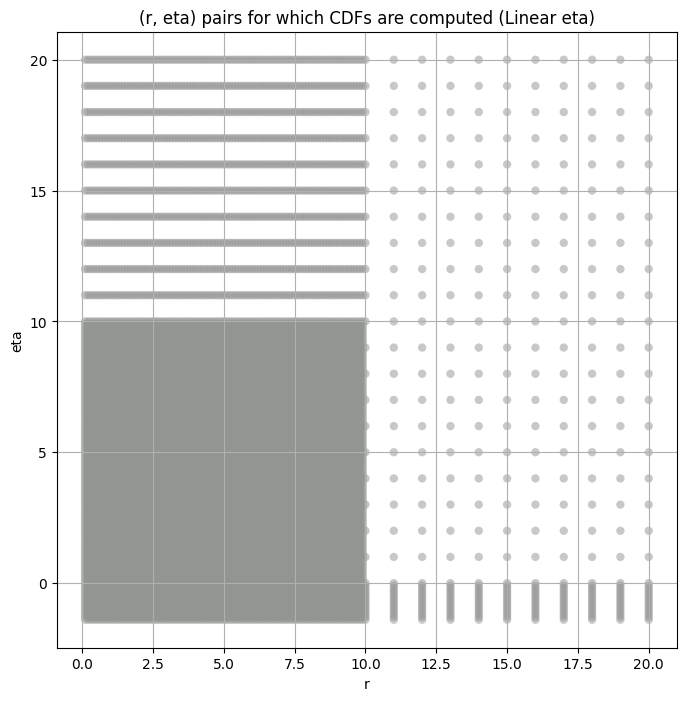

(r,eta),cdf    r  eta  \
0  ((0.1, -1.4), <scipy.interpolate._fitpack2.Int...  0.1 -1.4   
1  ((0.1, -1.3), <scipy.interpolate._fitpack2.Int...  0.1 -1.3   
2  ((0.1, -1.2), <scipy.interpolate._fitpack2.Int...  0.1 -1.2   
3  ((0.1, -1.1), <scipy.interpolate._fitpack2.Int...  0.1 -1.1   
4  ((0.1, -1.0), <scipy.interpolate._fitpack2.Int...  0.1 -1.0   

                                                 cdf      variance  \
0  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.628800e+06   
1  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.991680e+07   
2  <scipy.interpolate._fitpack2.InterpolatedUniva...  2.395008e+08   
3  <scipy.interpolate._fitpack2.InterpolatedUniva...  1.037837e+09   
4  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.632429e+09   

        kurtosis  
0  554265.000000  
1   96192.272727  
2   29390.000000  
3   11997.692308  
4    5874.890110

In [8]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
fine_cdfs_df = all_cdfs_df.copy()
all_cdfs_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 1) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 1) == all_cdfs_df['eta'])]
all_cdfs_df = all_cdfs_df.reset_index(drop=True)
all_cdfs = {x[0] : x[1] for x in all_cdfs_df["(r,eta),cdf"]}
                                             
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
print(f"Running {all_cdfs_df.shape[0]} CDFs")
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [9]:
n_bootstrap = int(1e5) # TODO For quick testing purposes
bootstrap_size = int(1e4) # TODO For quick testing purposes
ci = 0.99

In [10]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists(): # TODO For quick testing purposes
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

Band 2


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 5


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 8


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 11


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 14


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 18


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 21


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 24


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 27


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 31


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

obs_var     var_lower     var_upper   obs_kurt  kurt_lower  \
band                                                                    
2     6.853443e+08  6.000959e+08  7.770957e+08  22.937462   19.237597   
5     1.720905e+09  1.589508e+09  1.857453e+09   7.161636    6.278728   
8     1.589684e+09  1.483643e+09  1.698856e+09   4.965143    4.374576   
11    1.406791e+09  1.320917e+09  1.494175e+09   3.765583    3.402681   
14    4.136414e+08  3.796874e+08  4.487363e+08   8.555159    7.603021   
18    8.658497e+07  7.946839e+07  9.422107e+07   8.942694    7.117870   
21    3.366062e+07  3.053090e+07  3.707506e+07  11.999883    8.983744   
24    1.652805e+07  1.429403e+07  1.900538e+07  28.780750   22.489761   
27    7.214118e+06  6.049044e+06  8.504491e+06  41.735855   32.778020   
31    2.225652e+05  1.780760e+05  2.839582e+05  79.637880   42.826660   

      kurt_upper  total_samples  
band                             
2      27.805487     57630782.0  
5       8.114003     57630782.0  
8       5.578486     57630782.0  
11      4.146911     57630782.0  
14      9.561466     57630782.0  
18     11.266998     57630782.0  
21     16.473260     57630782.0  
24     36.190422     57630782.0  
27     52.597347     57630782.0  
31    217.259690     57630782.0

## Initial Grid Search and Hypothesis Test Plots

In [11]:
EXCLUDE_CUTOFFS = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 500] # TODO For quick testing purposes
SCALE_CAP = 1e5

In [12]:
augmented_var_df_path = Path(os.path.join(CWD, "CSVs", "augmented_var_df.csv"))
augmented_var_df = var_kurt_df[['obs_var']].copy()
augmented_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))

    augmented_var_df[f"var_exclude_{val}"] = temp_arr
augmented_var_df

obs_var  var_exclude_0  var_exclude_25  var_exclude_50  \
band                                                                
2     6.853443e+08   6.853443e+08    6.531425e+08    6.295404e+08   
5     1.720905e+09   1.720905e+09    1.685758e+09    1.656921e+09   
8     1.589684e+09   1.589684e+09    1.564778e+09    1.543079e+09   
11    1.406791e+09   1.406791e+09    1.391521e+09    1.377665e+09   
14    4.136414e+08   4.136414e+08    4.049490e+08    3.974971e+08   
18    8.658497e+07   8.658497e+07    8.389658e+07    8.197386e+07   
21    3.366062e+07   3.366062e+07    3.230911e+07    3.140495e+07   
24    1.652805e+07   1.652805e+07    1.548686e+07    1.474538e+07   
27    7.214118e+06   7.214118e+06    6.654045e+06    6.258518e+06   
31    2.225652e+05   2.225652e+05    1.954153e+05    1.804230e+05   

      var_exclude_75  var_exclude_100  var_exclude_150  var_exclude_200  \
band                                                                      
2       6.090039e+08     5.905016e+08     5.577544e+08     5.290929e+08   
5       1.630898e+09     1.606900e+09     1.563298e+09     1.523810e+09   
8       1.523199e+09     1.504716e+09     1.470916e+09     1.440281e+09   
11      1.364572e+09     1.352047e+09     1.328370e+09     1.306196e+09   
14      3.907017e+08     3.843845e+08     3.728364e+08     3.623889e+08   
18      8.033810e+07     7.888497e+07     7.635246e+07     7.416506e+07   
21      3.065782e+07     3.000735e+07     2.889667e+07     2.795981e+07   
24      1.412985e+07     1.359636e+07     1.269721e+07     1.195256e+07   
27      5.931976e+06     5.650389e+06     5.179416e+06     4.792290e+06   
31      1.685755e+05     1.587506e+05     1.429998e+05     1.306295e+05   

      var_exclude_250  var_exclude_300  var_exclude_350  var_exclude_500  
band                                                                      
2        5.033914e+08     4.800567e+08     4.587632e+08     4.044671e+08  
5        1.487457e+09     1.453656e+09     1.422010e+09     1.337316e+09  
8        1.412063e+09     1.385807e+09     1.361184e+09     1.294695e+09  
11       1.285229e+09     1.265280e+09     1.246207e+09     1.193313e+09  
14       3.527971e+08     3.438871e+08     3.355520e+08     3.132428e+08  
18       7.222218e+07     7.046500e+07     6.885485e+07     6.467993e+07  
21       2.714369e+07     2.641762e+07     2.576129e+07     2.408953e+07  
24       1.131696e+07     1.076314e+07     1.027334e+07     9.081749e+06  
27       4.463948e+06     4.179622e+06     3.929575e+06     3.327184e+06  
31       1.205021e+05     1.119741e+05     1.046537e+05     8.762201e+04

####
Band  2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 0 0.01297001665314812 685344260.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 25 0.011944610641055675 653142460.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 50 0.012692112690676827 629540400.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 75 0.013372664647815138 609003900.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 100 0.01401182222706765 590501570.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 150 0.01354751138706145 557754430.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 200 0.014630330947371567 529092860.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 250 0.015665451404474284 503391360.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 300 0.01526271514597528 480056740.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 350 0.016197906442461697 458763200.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 500 0.017636655680073877 404467100.0
Number of samples: 100000, Without approximation : 57630782.0


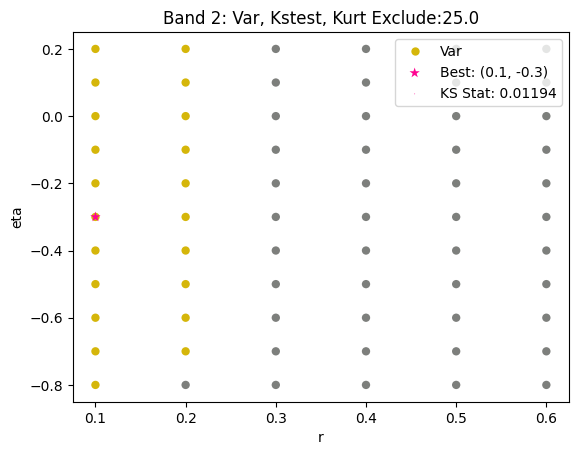

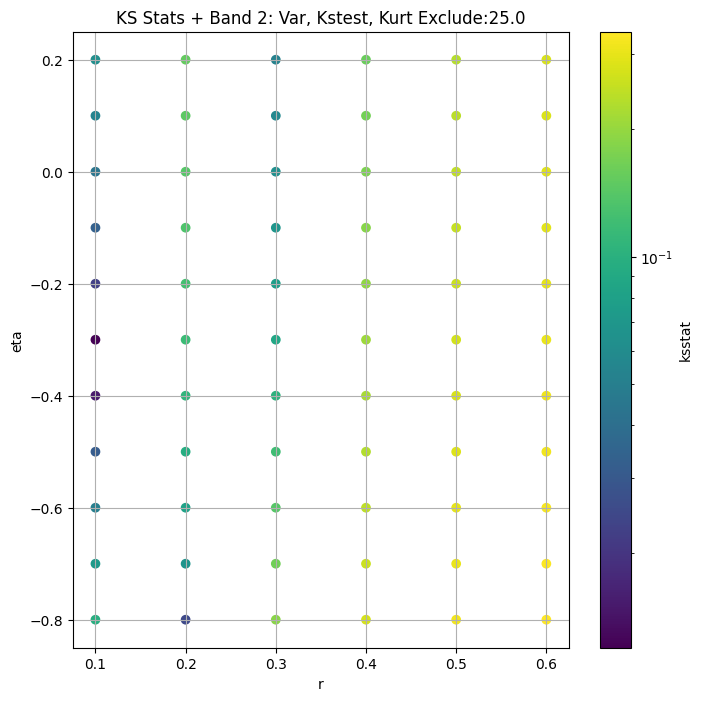

####
Band  5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 0 0.035515335025095865 1720905300.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 25 0.03651979915666437 1685758200.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 50 0.03687804023867203 1656921300.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 75 0.03687804023867203 1630897700.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 100 0.036787579741309584 1606900200.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 150 0.03687804023867203 1563298400.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 200 0.03687804023867203 1523810000.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 250 0.036266435375981954 1487456500.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 300 0.035403645061979794 1453656400.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 350 0.03458784741138976 1422010500.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 500 0.03598496261186104 1337316200.0
Number of samples: 100000, Without approximation : 57630782.0


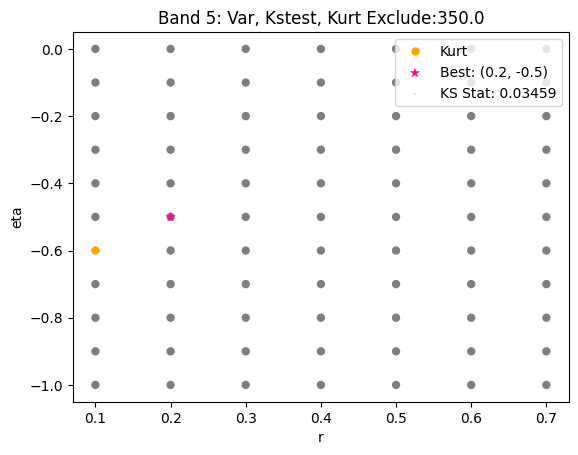

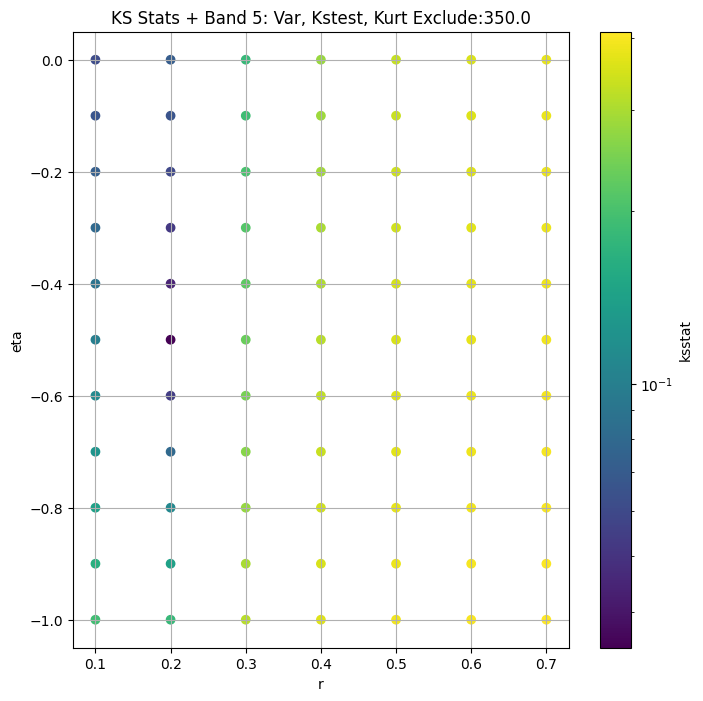

####
Band  8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 0 0.025057729179109797 1589683800.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 25 0.02608717071916833 1564777700.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 50 0.026995891196314847 1543078700.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 75 0.026863005706505294 1523199100.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 100 0.02653356288640818 1504715900.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 150 0.026432666207257288 1470915600.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 200 0.027797307326141274 1440281200.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 250 0.028502810562468284 1412062700.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 300 0.027984737468473186 1385806800.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 350 0.02832751288279156 1361183900.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 500 0.029449285965139405 1294695400.0
Number of samples: 100000, Without approximation : 57630782.0


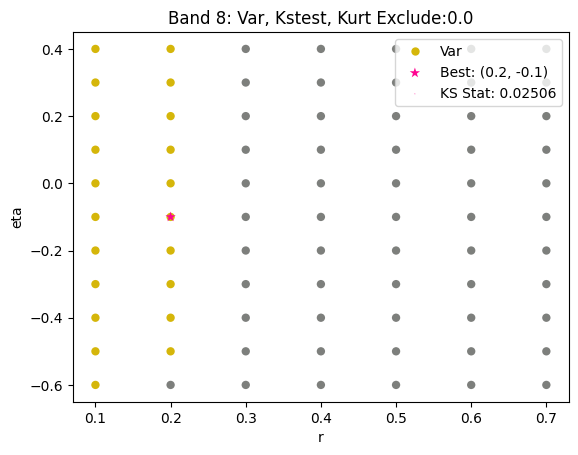

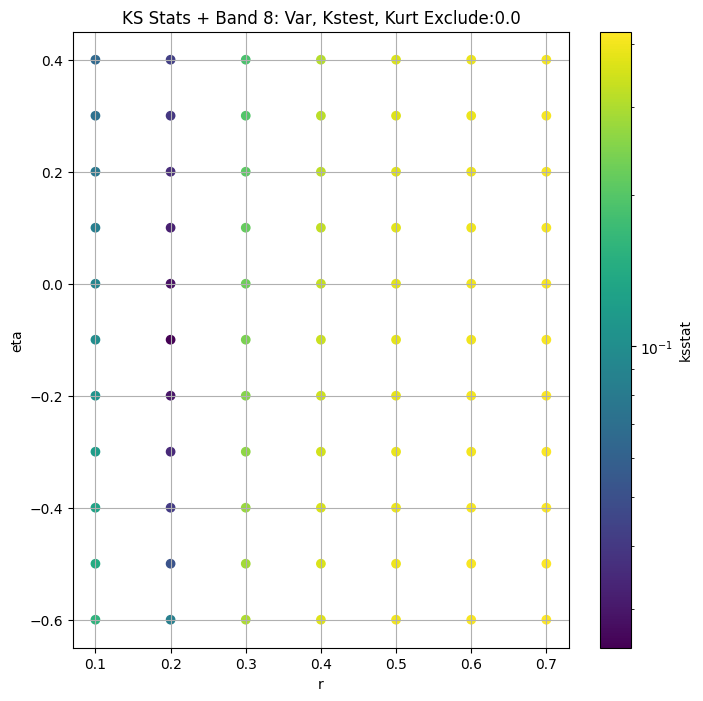

####
Band  11


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 0 0.029153932250075454 1406790700.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 25 0.02977373331842803 1391520600.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 50 0.030342702460982696 1377664600.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 75 0.030161065851386226 1364571500.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 100 0.029847201138950563 1352046800.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 150 0.029352629802514213 1328370400.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 200 0.03030508798879787 1306195700.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 250 0.031222830321796985 1285228700.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 300 0.032111686998940514 1265279900.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 350 0.03205302455624459 1246207500.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 500 0.03283876218903968 1193312500.0
Number of samples: 100000, Without approximation : 57630782.0


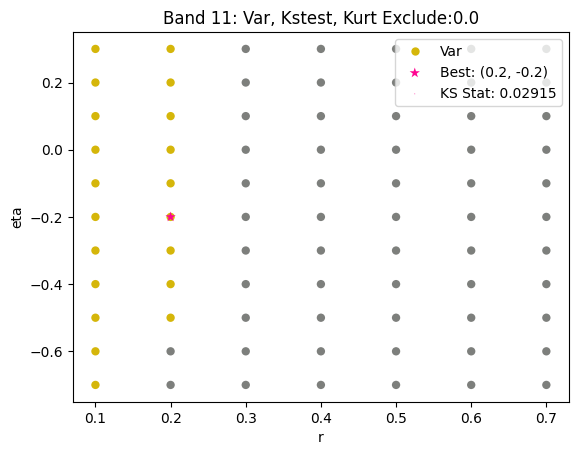

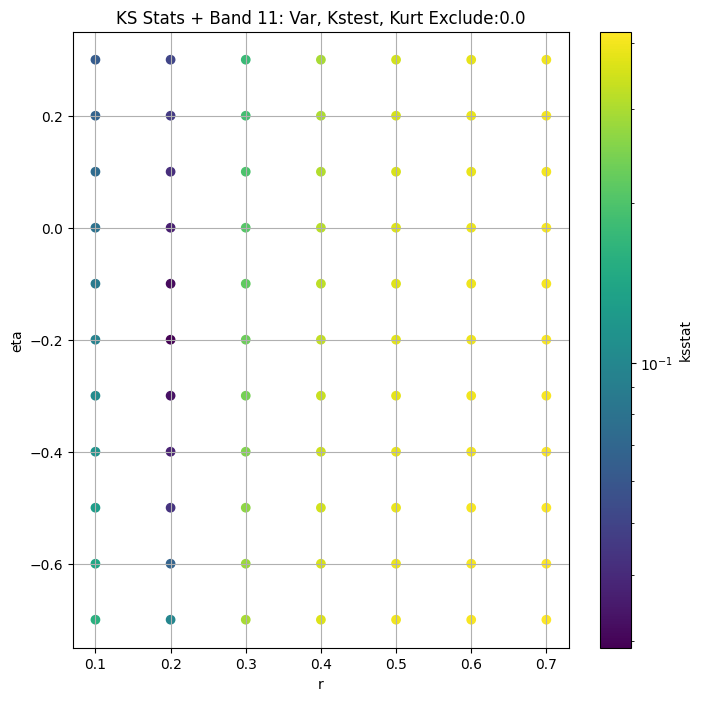

####
Band  14


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 0 0.019815088457874053 413641380.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 25 0.01952769265749106 404948960.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 50 0.020437219906753498 397497120.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 75 0.02128791743199407 390701700.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 100 0.02209697075832112 384384540.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 150 0.023614210195503665 372836450.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 200 0.025031454286135832 362388930.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 250 0.02464130292746136 352797100.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 300 0.02374667077209247 343887070.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 350 0.024024435308877656 335552000.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 500 0.02740484365305071 313242800.0
Number of samples: 100000, Without approximation : 57630782.0


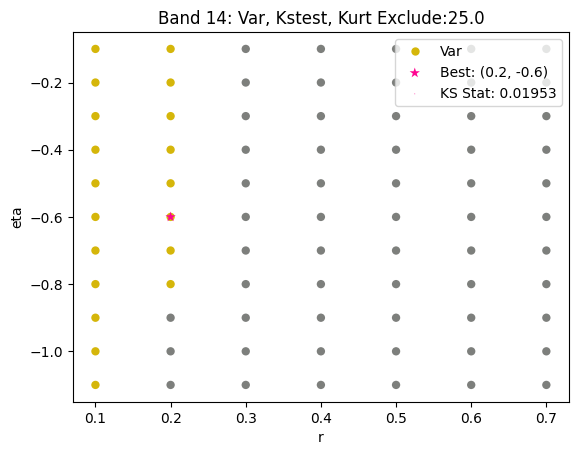

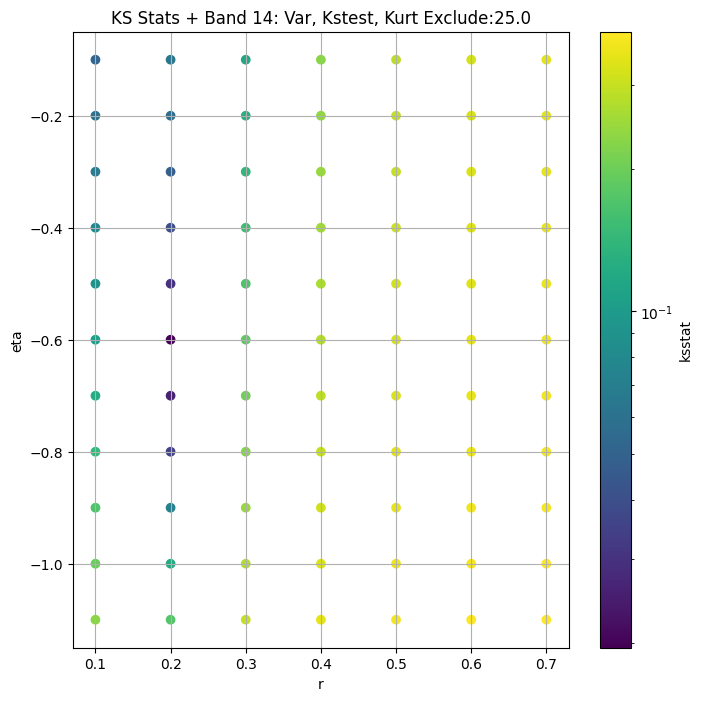

####
Band  18


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
18 0 0.019641511773415832 86584970.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
18 25 0.021435190457334635 83896584.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
18 50 0.02082614622640211 81973864.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
18 75 0.020323009118771468 80338104.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
18 100 0.021332768968751054 78884970.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
18 150 0.023157011079209977 76352460.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
18 200 0.022859687896890524 74165064.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
18 250 0.023339546401609623 72222184.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
18 300 0.024706316563919972 70465000.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
18 350 0.025126770088370165 68854850.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
18 500 0.026999201442988507 64679930.0
Number of samples: 100000, Without approximation : 57630782.0


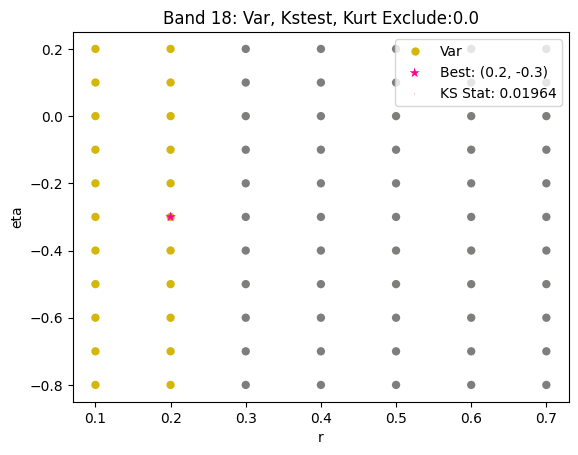

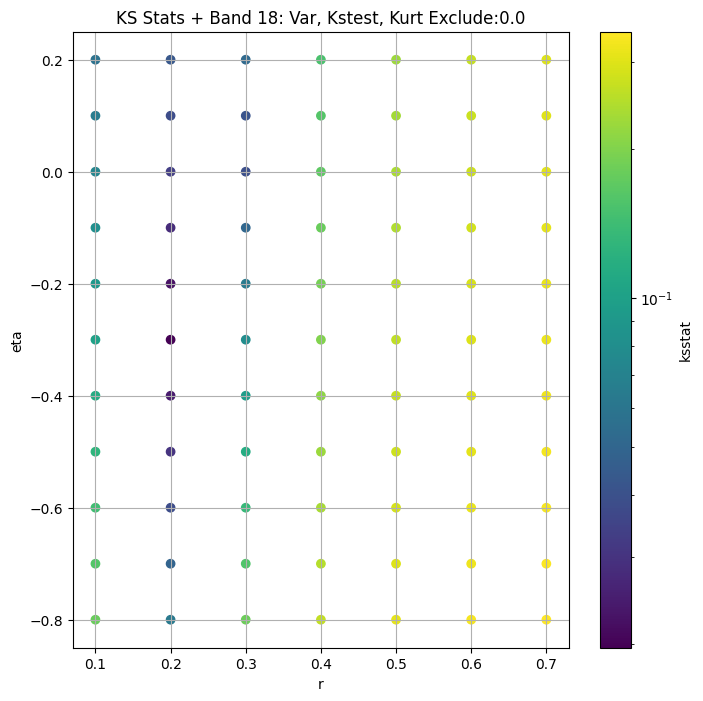

####
Band  21


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
21 0 0.018455833543883998 33660616.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
21 25 0.020685933156070632 32309108.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
21 50 0.021272223656318645 31404946.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
21 75 0.020609969333491684 30657816.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
21 100 0.020037313421874203 30007346.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
21 150 0.02197914965369463 28896666.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
21 200 0.023734025254990188 27959814.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
21 250 0.02364285996576443 27143692.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
21 300 0.023062173969281896 26417624.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
21 350 0.02437246991336192 25761294.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
21 500 0.02590235134570784 24089534.0
Number of samples: 100000, Without approximation : 57630782.0


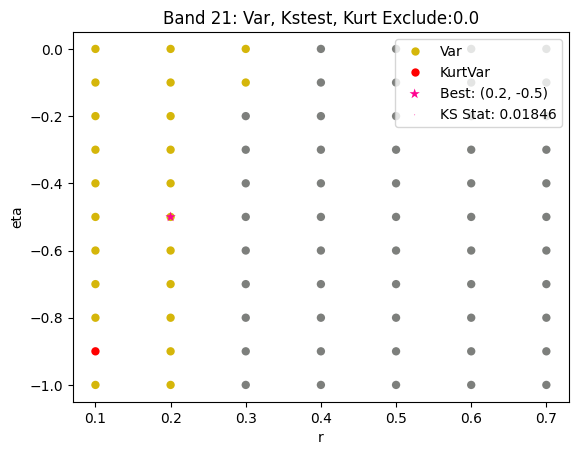

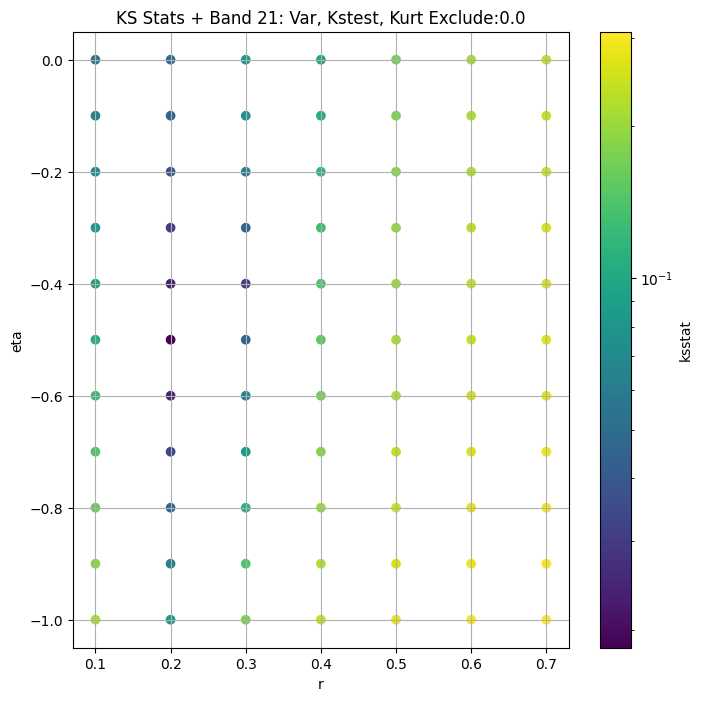

####
Band  24


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
24 0 0.006889003530982207 16528046.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
24 25 0.009318427162095175 15486863.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
24 50 0.011677276753011973 14745385.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
24 75 0.013766836848341624 14129850.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
24 100 0.01566152774547333 13596365.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
24 150 0.016618073426621582 12697208.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
24 200 0.014579161232415094 11952556.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
24 250 0.014780444158805528 11316959.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
24 300 0.016904411738250996 10763137.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
24 350 0.018987014289283066 10273345.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
24 500 0.020209743634364896 9081749.0
Number of samples: 100000, Without approximation : 57630782.0


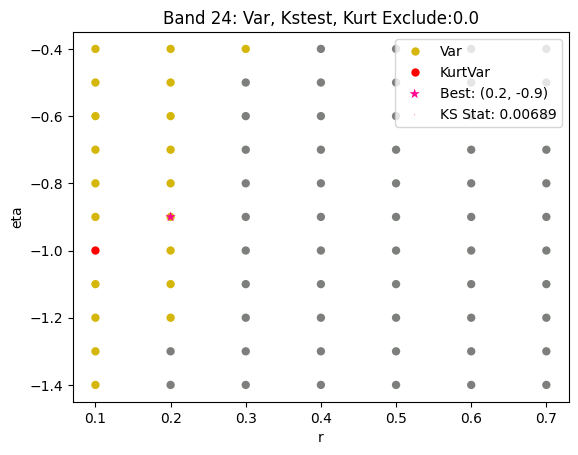

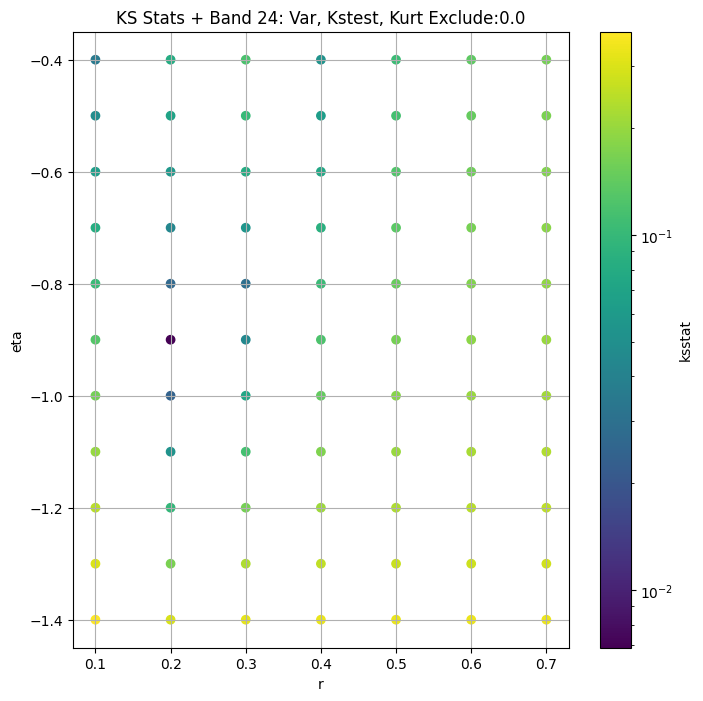

####
Band  27


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
27 0 0.013057098100439757 7214117.5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
27 25 0.012547738561948685 6654045.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
27 50 0.010262467973975842 6258517.5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
27 75 0.010172846156765947 5931976.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
27 100 0.010094757658693276 5650389.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
27 150 0.009964004438491991 5179416.5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
27 200 0.00985166802655113 4792289.5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
27 250 0.009753997712281692 4463948.5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
27 300 0.011421475911674833 4179622.2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
27 350 0.014574528846450524 3929574.8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
27 500 0.013939960523194794 3327183.5
Number of samples: 100000, Without approximation : 57630782.0


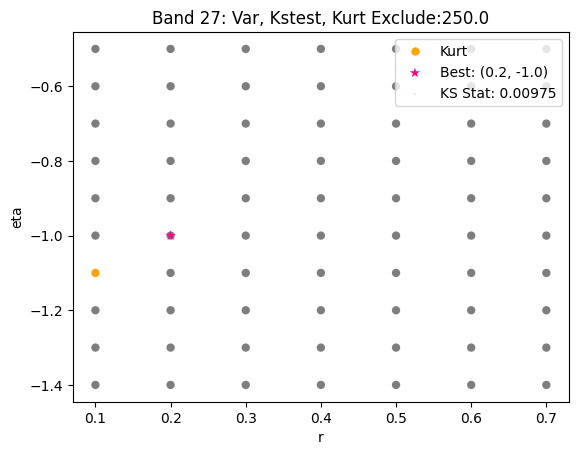

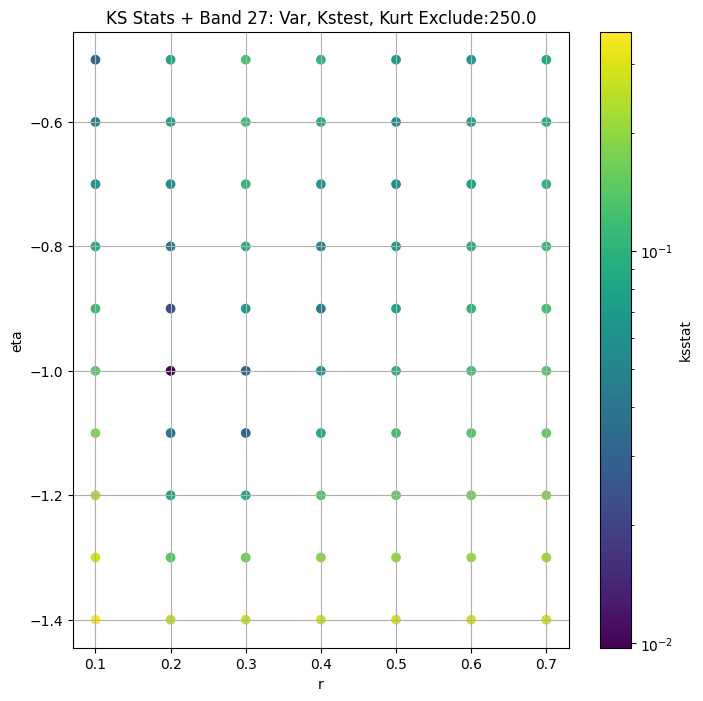

####
Band  31


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
31 0 0.028833351531736162 222565.25


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
31 25 0.02868519729501018 195415.28


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
31 50 0.028595840775144654 180423.02


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
31 75 0.02851947497271079 168575.47


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
31 100 0.02845226355331587 158750.61


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
31 150 0.028752045585838326 142999.8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
31 200 0.028650408025395924 130629.5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
31 250 0.028559375766953332 120502.09


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
31 300 0.028478056096114868 111974.07


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
31 350 0.02840304570848362 104653.73


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
31 500 0.02963657504823891 87622.01
Number of samples: 100000, Without approximation : 57630782.0


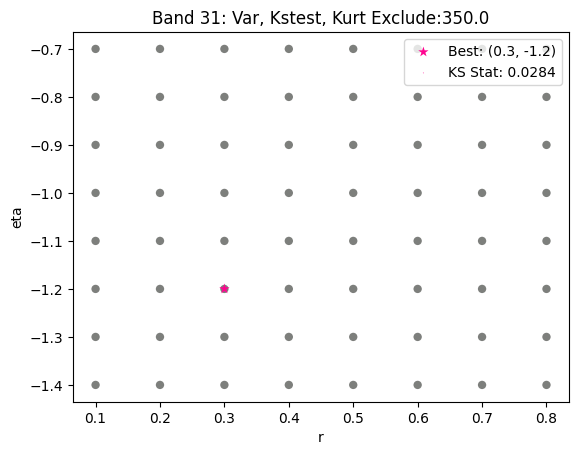

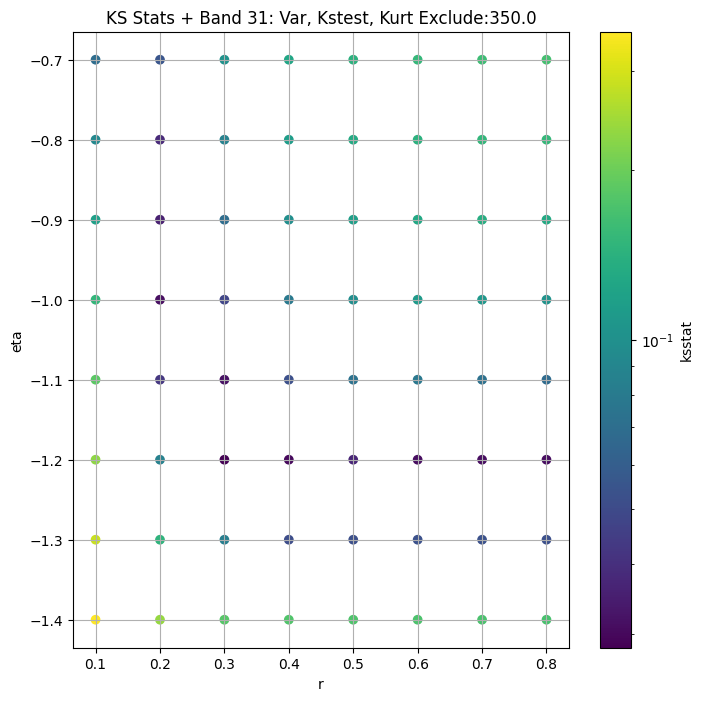

obs_var     var_lower     var_upper   obs_kurt  kurt_lower  \
band                                                                    
2     6.853443e+08  6.000959e+08  7.770957e+08  22.937462   19.237597   
5     1.720905e+09  1.589508e+09  1.857453e+09   7.161636    6.278728   
8     1.589684e+09  1.483643e+09  1.698856e+09   4.965143    4.374576   
11    1.406791e+09  1.320917e+09  1.494175e+09   3.765583    3.402681   
14    4.136414e+08  3.796874e+08  4.487363e+08   8.555159    7.603021   
18    8.658497e+07  7.946839e+07  9.422107e+07   8.942694    7.117870   
21    3.366062e+07  3.053090e+07  3.707506e+07  11.999883    8.983744   
24    1.652805e+07  1.429403e+07  1.900538e+07  28.780750   22.489761   
27    7.214118e+06  6.049044e+06  8.504491e+06  41.735855   32.778020   
31    2.225652e+05  1.780760e+05  2.839582e+05  79.637880   42.826660   

      kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
band                                                                           
2      27.805487     57630782.0             0.011945        0.1         -0.3   
5       8.114003     57630782.0             0.034588        0.2         -0.5   
8       5.578486     57630782.0             0.025058        0.2         -0.1   
11      4.146911     57630782.0             0.029154        0.2         -0.2   
14      9.561466     57630782.0             0.019528        0.2         -0.6   
18     11.266998     57630782.0             0.019642        0.2         -0.3   
21     16.473260     57630782.0             0.018456        0.2         -0.5   
24     36.190422     57630782.0             0.006889        0.2         -0.9   
27     52.597347     57630782.0             0.009754        0.2         -1.0   
31    217.259690     57630782.0             0.028403        0.3         -1.2   

      initial_scale  initial_exclude_cutoff  best_augmented_var  \
band                                                              
2          0.000510                    25.0        6.531425e+08   
5      94048.313228                   350.0        1.422010e+09   
8      28673.950938                     0.0        1.589684e+09   
11     34034.786054                     0.0        1.406791e+09   
14     39484.945138                    25.0        4.049490e+08   
18      2863.259524                     0.0        8.658497e+07   
21      2226.231217                     0.0        3.366062e+07   
24      6558.748413                     0.0        1.652805e+07   
27      3171.192186                   250.0        4.463948e+06   
31     11301.053626                   350.0        1.046537e+05   

      kstest_stat_cutoff_0.05  
band                           
2                    0.000179  
5                    0.000179  
8                    0.000179  
11                   0.000179  
14                   0.000179  
18                   0.000179  
21                   0.000179  
24                   0.000179  
27                   0.000179  
31                   0.000179

In [13]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))

rEtaKsstats_dict = dict()

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS): # TODO For quick testing purposes
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        if len(sample) == 0:
            continue
        group_cdfs_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1

        for j in range(len(EXCLUDE_CUTOFFS)):

            exclude_cutoff = EXCLUDE_CUTOFFS[j]
            exclude_cutoff = int(exclude_cutoff)

            if exclude_cutoff == 0:
                augmented_var = np.var(group_data_map[group]) 
            else:
                augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                if augmented_var == np.var(group_data_map[group]):
                    continue 
                
            group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdfs_df['scale'])
            augmented_var_df.loc[group, f"kstest_stat_{exclude_cutoff}"] = min_stat
            group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] = ksstats
            
            print(group, exclude_cutoff, min_stat, augmented_var)
            
            if (min_stat < master_df.loc[group, 'kstest_stat_initial']) and not np.isclose(min_stat, master_df.loc[group, 'kstest_stat_initial'], 1e-6):
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'initial_exclude_cutoff'] = exclude_cutoff
                master_df.loc[group, 'best_augmented_var'] = augmented_var
        
        ksstats = group_cdfs_df[f"ksstat_exclude_{int(master_df.loc[group, 'initial_exclude_cutoff'])}"]
            
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

        group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
        group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

        group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

        group_dict = {'r' : group_cdfs_df['r'], 'eta' : group_cdfs_df['eta']}
        group_dict.update({f'ksstat_exclude_{exclude_cutoff}' : group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS[:j+1]})
        rEtaKsstats_dict[group] = group_dict

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdfs_df, cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} Exclude:{master_df.loc[group, 'initial_exclude_cutoff']}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdfs_df, var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdfs_df, kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(master_df_combo_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)
    augmented_var_df.to_csv(augmented_var_df_path)

augmented_var_df = pd.read_csv(augmented_var_df_path, index_col=GROUP)
master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df

## Optimization

In [14]:
master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
master_df[f'best_r'] = master_df['initial_r']
master_df[f'best_eta'] = master_df['initial_eta']
master_df[f'best_scale'] = master_df['initial_scale']
master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

Band 2


  0%|          | 0/882 [00:00<?, ?it/s]

Finding Minimum after computing 882 CDFs
band 2, 25.0 + 100 = 125, ksstat: 0.012841995023584407, var: 573517568.0


  0%|          | 0/882 [00:00<?, ?it/s]

Finding Minimum after computing 882 CDFs
band 2, 25.0 + 75 = 100, ksstat: 0.012256081829808068, var: 590501568.0


  0%|          | 0/882 [00:00<?, ?it/s]

Finding Minimum after computing 882 CDFs
band 2, 25.0 + 50 = 75, ksstat: 0.011739166354573814, var: 609003904.0


  0%|          | 0/882 [00:00<?, ?it/s]

Finding Minimum after computing 882 CDFs
band 2, 25.0 + 25 = 50, ksstat: 0.011079633031634284, var: 629540416.0


  0%|          | 0/882 [00:00<?, ?it/s]

Finding Minimum after computing 882 CDFs
band 2, 25.0 + 0 = 25, ksstat: 0.011944610641055675, var: 653142464.0


  0%|          | 0/882 [00:00<?, ?it/s]

Finding Minimum after computing 882 CDFs
band 2, 25.0 + -25 = 0, ksstat: 0.011385352662132697, var: 685344256.0
Number of samples: 100000, Without approximation : 57630782.0


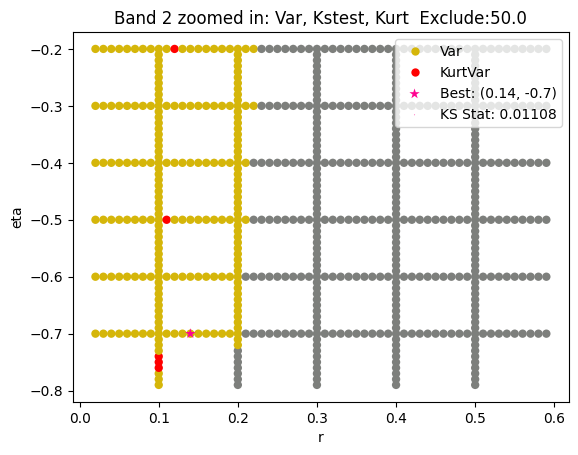

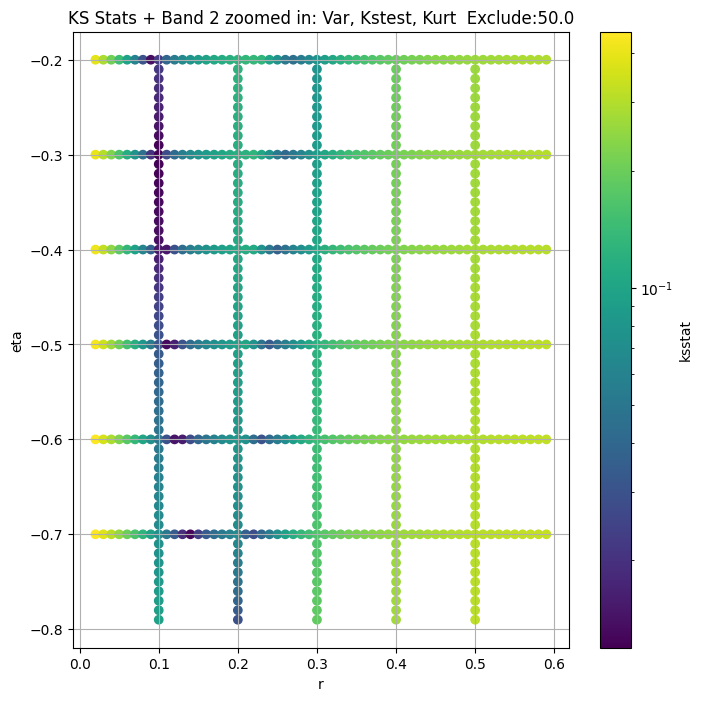

Band 5


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
band 5, 350.0 + 100 = 450, ksstat: 0.034630494590937366, var: 1364033536.0


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
band 5, 350.0 + 75 = 425, ksstat: 0.034409606789083835, var: 1377928576.0


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
band 5, 350.0 + 50 = 400, ksstat: 0.034044995279995605, var: 1392209280.0


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
band 5, 350.0 + 25 = 375, ksstat: 0.0339487168733375, var: 1406895616.0


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
band 5, 350.0 + 0 = 350, ksstat: 0.03359531243617658, var: 1422010496.0


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
band 5, 350.0 + -25 = 325, ksstat: 0.033994951639575055, var: 1437585664.0


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
band 5, 350.0 + -50 = 300, ksstat: 0.034357056572014266, var: 1453656448.0


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
band 5, 350.0 + -75 = 275, ksstat: 0.03430342194662539, var: 1470264832.0


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
band 5, 350.0 + -100 = 250, ksstat: 0.03374078146254257, var: 1487456512.0
Number of samples: 100000, Without approximation : 57630782.0


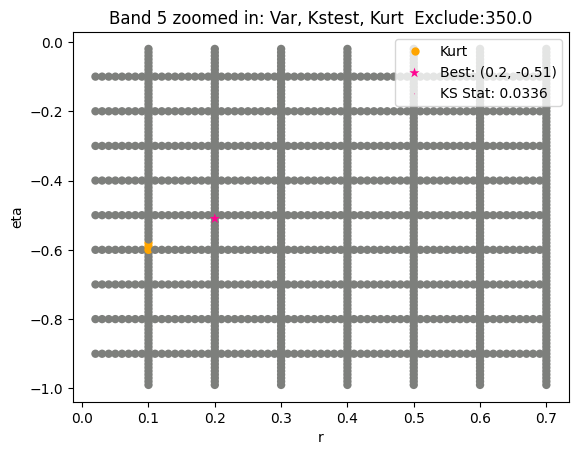

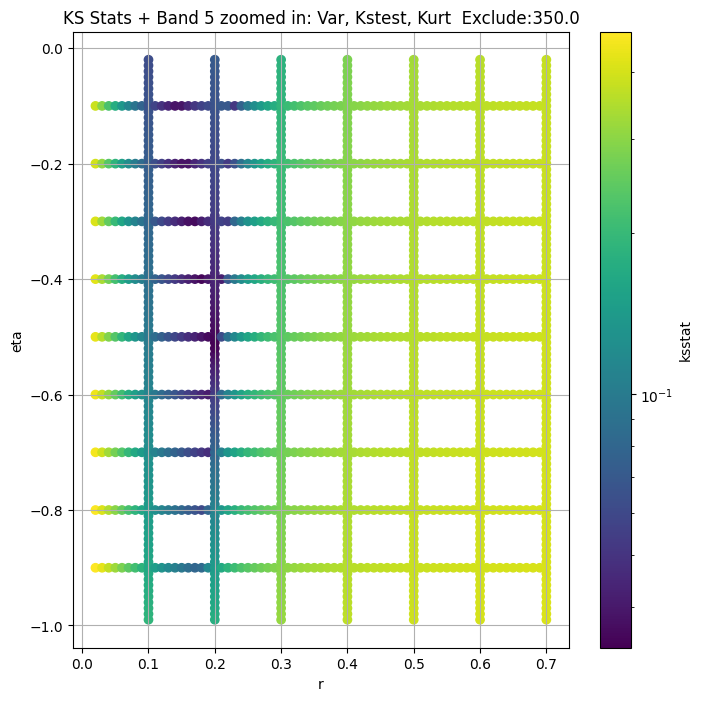

Band 8


  0%|          | 0/999 [00:00<?, ?it/s]

Finding Minimum after computing 999 CDFs
band 8, 0.0 + 100 = 100, ksstat: 0.025444219760765954, var: 1504715904.0


  0%|          | 0/999 [00:00<?, ?it/s]

Finding Minimum after computing 999 CDFs
band 8, 0.0 + 75 = 75, ksstat: 0.025557598364970513, var: 1523199104.0


  0%|          | 0/999 [00:00<?, ?it/s]

Finding Minimum after computing 999 CDFs
band 8, 0.0 + 50 = 50, ksstat: 0.025232914523509287, var: 1543078656.0


  0%|          | 0/999 [00:00<?, ?it/s]

Finding Minimum after computing 999 CDFs
band 8, 0.0 + 25 = 25, ksstat: 0.0249166278683524, var: 1564777728.0


  0%|          | 0/999 [00:00<?, ?it/s]

Finding Minimum after computing 999 CDFs
band 8, 0.0 + 0 = 0, ksstat: 0.024662872551201753, var: 1589683840.0
Number of samples: 100000, Without approximation : 57630782.0


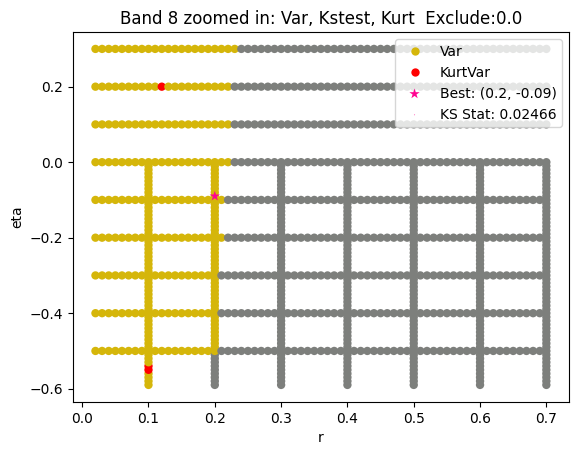

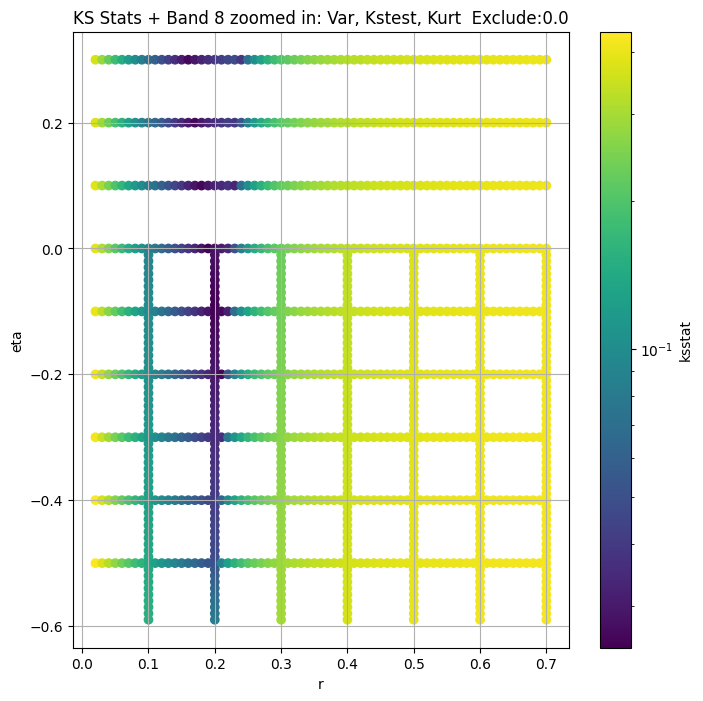

Band 11


  0%|          | 0/1131 [00:00<?, ?it/s]

Finding Minimum after computing 1131 CDFs
band 11, 0.0 + 100 = 100, ksstat: 0.028837449330748388, var: 1352046848.0


  0%|          | 0/1131 [00:00<?, ?it/s]

Finding Minimum after computing 1131 CDFs
band 11, 0.0 + 75 = 75, ksstat: 0.028315912106221586, var: 1364571520.0


  0%|          | 0/1131 [00:00<?, ?it/s]

Finding Minimum after computing 1131 CDFs
band 11, 0.0 + 50 = 50, ksstat: 0.02844403334723733, var: 1377664640.0


  0%|          | 0/1131 [00:00<?, ?it/s]

Finding Minimum after computing 1131 CDFs
band 11, 0.0 + 25 = 25, ksstat: 0.028177830115693858, var: 1391520640.0


  0%|          | 0/1131 [00:00<?, ?it/s]

Finding Minimum after computing 1131 CDFs
band 11, 0.0 + 0 = 0, ksstat: 0.02791999099915321, var: 1406790656.0
Number of samples: 100000, Without approximation : 57630782.0


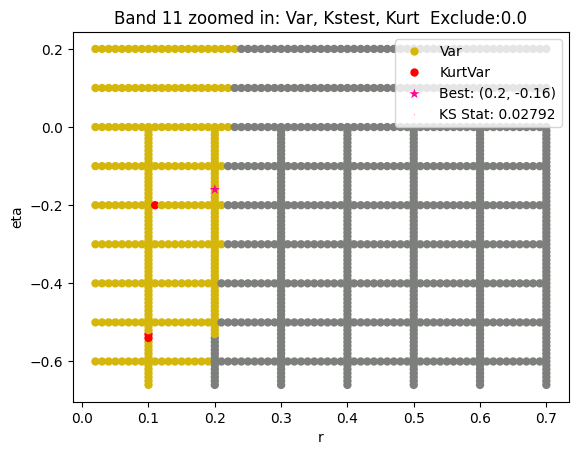

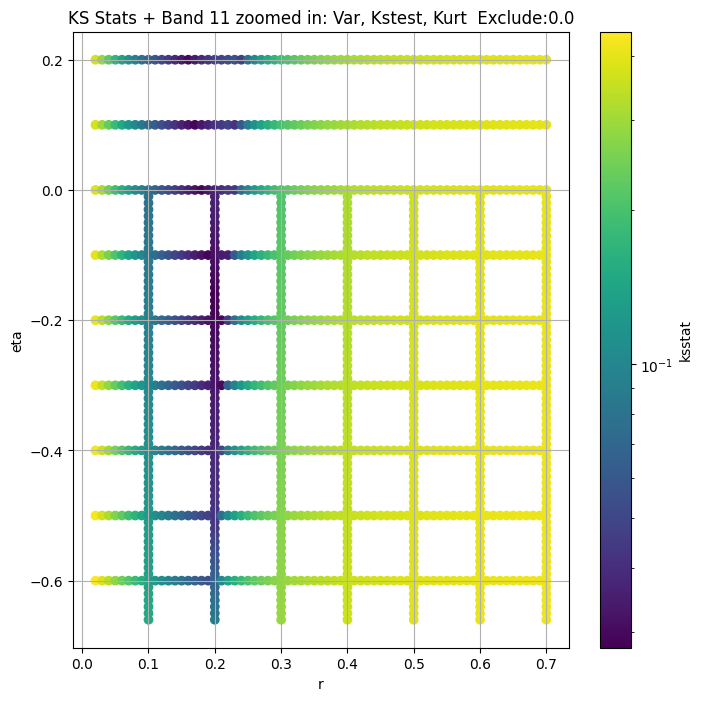

Band 14


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
band 14, 25.0 + 100 = 125, ksstat: 0.021094749469630747, var: 378451872.0


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
band 14, 25.0 + 75 = 100, ksstat: 0.020578983354179625, var: 384384544.0


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
band 14, 25.0 + 50 = 75, ksstat: 0.02024990585552318, var: 390701696.0


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
band 14, 25.0 + 25 = 50, ksstat: 0.01991557248399034, var: 397497120.0


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
band 14, 25.0 + 0 = 25, ksstat: 0.01952769265749106, var: 404948960.0


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
band 14, 25.0 + -25 = 0, ksstat: 0.01902146102765899, var: 413641376.0
Number of samples: 100000, Without approximation : 57630782.0


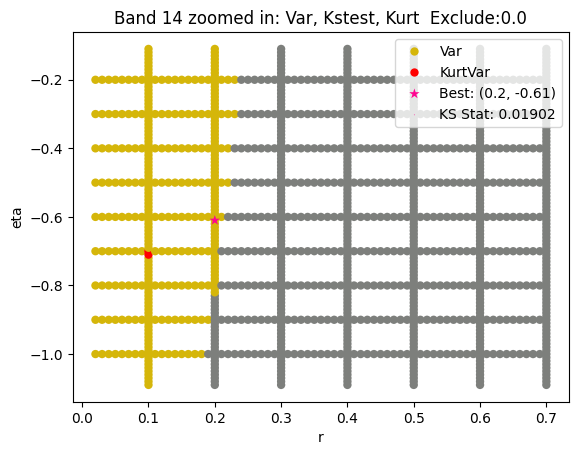

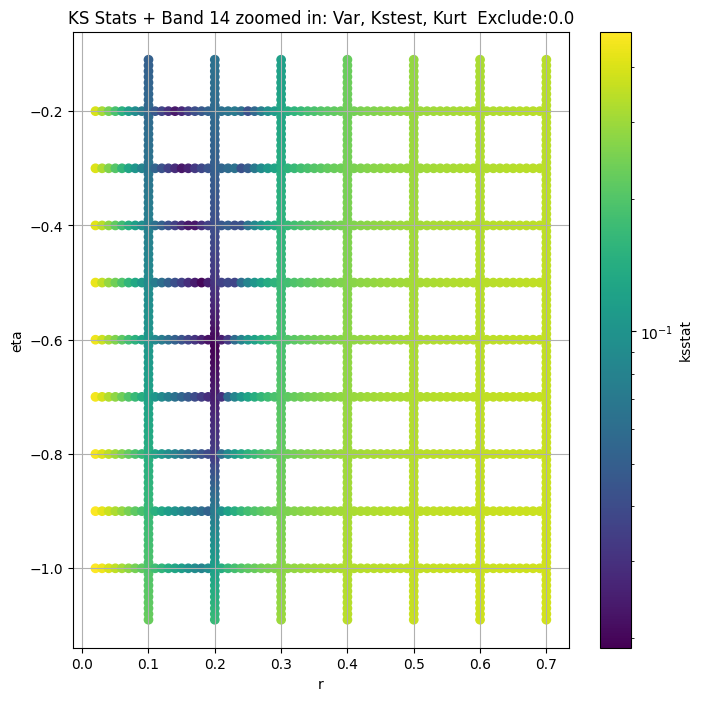

Band 18


  0%|          | 0/1125 [00:00<?, ?it/s]

Finding Minimum after computing 1125 CDFs
band 18, 0.0 + 100 = 100, ksstat: 0.020132717907335285, var: 78884968.0


  0%|          | 0/1125 [00:00<?, ?it/s]

Finding Minimum after computing 1125 CDFs
band 18, 0.0 + 75 = 75, ksstat: 0.019321103722870048, var: 80338104.0


  0%|          | 0/1125 [00:00<?, ?it/s]

Finding Minimum after computing 1125 CDFs
band 18, 0.0 + 50 = 50, ksstat: 0.018203649386990636, var: 81973864.0


  0%|          | 0/1125 [00:00<?, ?it/s]

Finding Minimum after computing 1125 CDFs
band 18, 0.0 + 25 = 25, ksstat: 0.017950946225371855, var: 83896584.0


  0%|          | 0/1125 [00:00<?, ?it/s]

Finding Minimum after computing 1125 CDFs
band 18, 0.0 + 0 = 0, ksstat: 0.017316724140655895, var: 86584968.0
Number of samples: 100000, Without approximation : 57630782.0


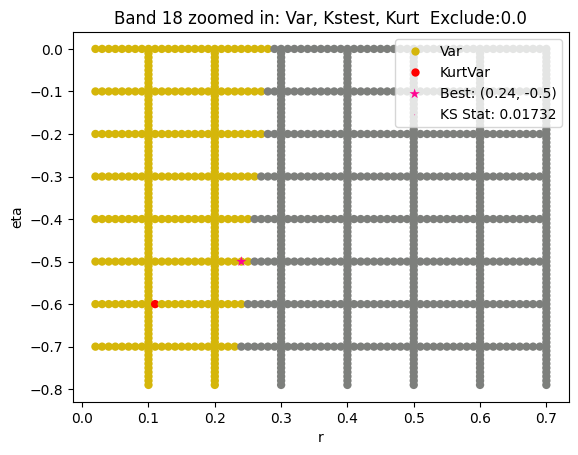

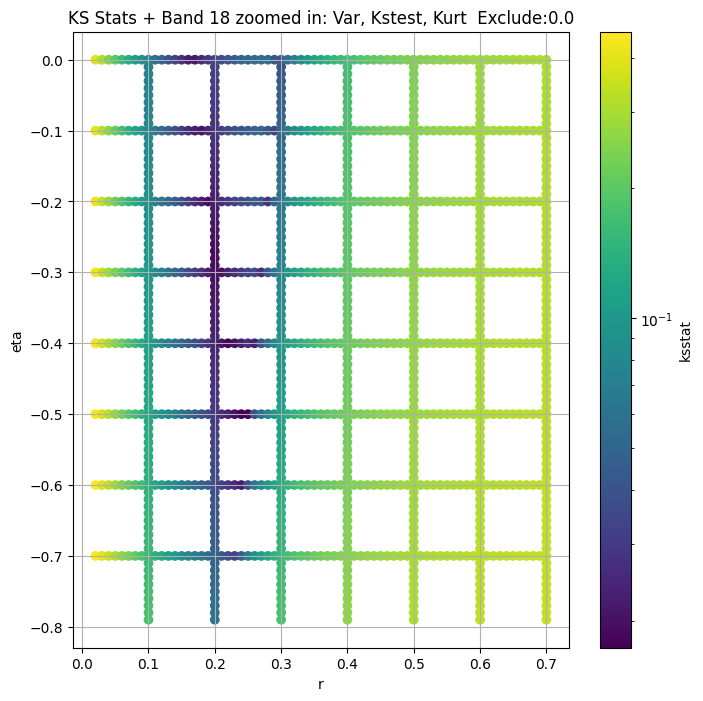

Band 21


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
band 21, 0.0 + 100 = 100, ksstat: 0.018346632661252485, var: 30007346.0


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
band 21, 0.0 + 75 = 75, ksstat: 0.018401572974914293, var: 30657816.0


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
band 21, 0.0 + 50 = 50, ksstat: 0.018380255209613644, var: 31404946.0


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
band 21, 0.0 + 25 = 25, ksstat: 0.01688428775998027, var: 32309108.0


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
band 21, 0.0 + 0 = 0, ksstat: 0.015062658556031505, var: 33660616.0
Number of samples: 100000, Without approximation : 57630782.0


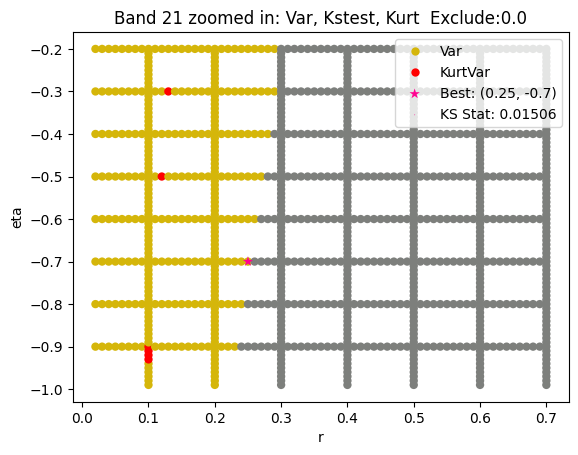

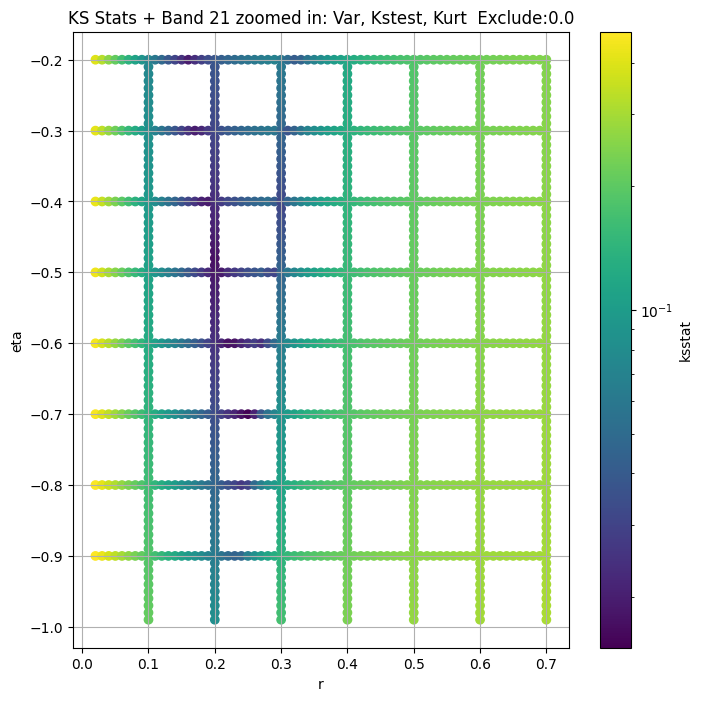

Band 24


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
band 24, 0.0 + 100 = 100, ksstat: 0.010535335216234107, var: 13596365.0


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
band 24, 0.0 + 75 = 75, ksstat: 0.009166122048724343, var: 14129850.0


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
band 24, 0.0 + 50 = 50, ksstat: 0.007252487922421391, var: 14745385.0


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
band 24, 0.0 + 25 = 25, ksstat: 0.005379807917102991, var: 15486863.0


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
band 24, 0.0 + 0 = 0, ksstat: 0.005659980059353531, var: 16528046.0
Number of samples: 100000, Without approximation : 57630782.0


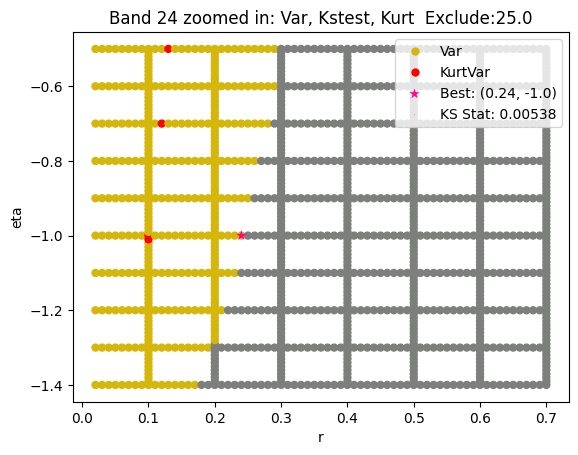

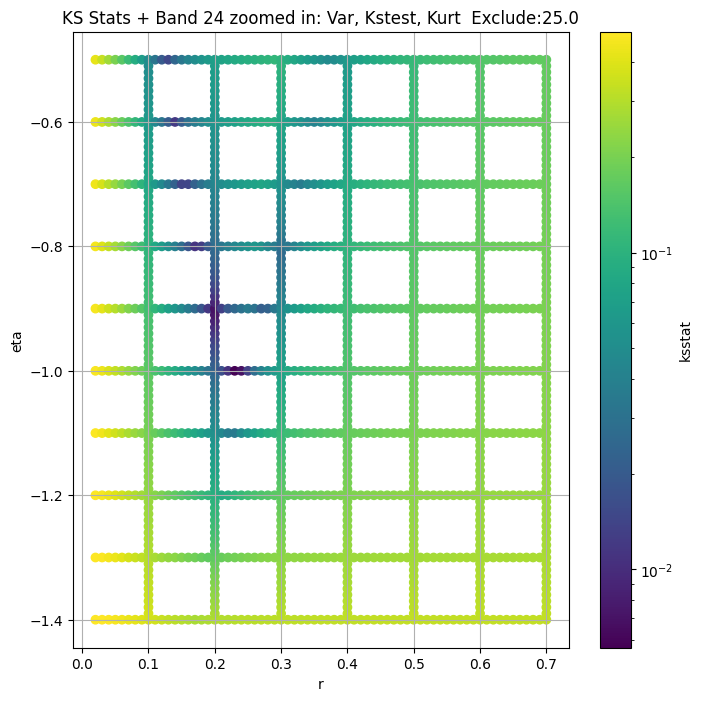

Band 27


  0%|          | 0/1223 [00:00<?, ?it/s]

Finding Minimum after computing 1223 CDFs
band 27, 250.0 + 100 = 350, ksstat: 0.008716537835234961, var: 3929574.75


  0%|          | 0/1223 [00:00<?, ?it/s]

Finding Minimum after computing 1223 CDFs
band 27, 250.0 + 75 = 325, ksstat: 0.008548888528106091, var: 4050760.0


  0%|          | 0/1223 [00:00<?, ?it/s]

Finding Minimum after computing 1223 CDFs
band 27, 250.0 + 50 = 300, ksstat: 0.0085776682391423, var: 4179622.25


  0%|          | 0/1223 [00:00<?, ?it/s]

Finding Minimum after computing 1223 CDFs
band 27, 250.0 + 25 = 275, ksstat: 0.008607216313732902, var: 4316996.5


  0%|          | 0/1223 [00:00<?, ?it/s]

Finding Minimum after computing 1223 CDFs
band 27, 250.0 + 0 = 250, ksstat: 0.008638332719584252, var: 4463948.5


  0%|          | 0/1223 [00:00<?, ?it/s]

Finding Minimum after computing 1223 CDFs
band 27, 250.0 + -25 = 225, ksstat: 0.008459774054821012, var: 4621830.5


  0%|          | 0/1223 [00:00<?, ?it/s]

Finding Minimum after computing 1223 CDFs
band 27, 250.0 + -50 = 200, ksstat: 0.008493239349735171, var: 4792289.5


  0%|          | 0/1223 [00:00<?, ?it/s]

Finding Minimum after computing 1223 CDFs
band 27, 250.0 + -75 = 175, ksstat: 0.008528221688377191, var: 4977311.5


  0%|          | 0/1223 [00:00<?, ?it/s]

Finding Minimum after computing 1223 CDFs
band 27, 250.0 + -100 = 150, ksstat: 0.00856471022526406, var: 5179416.5
Number of samples: 100000, Without approximation : 57630782.0


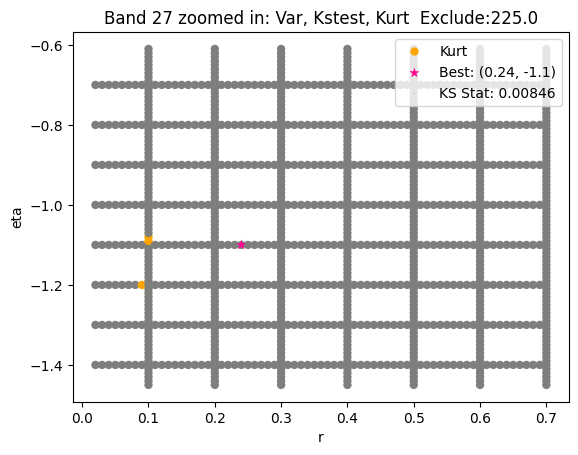

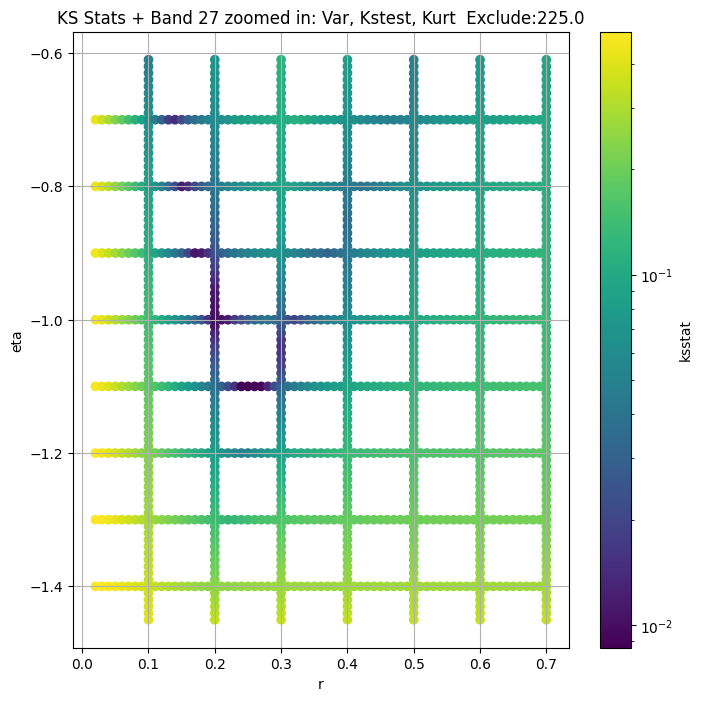

Band 31


  0%|          | 0/1022 [00:00<?, ?it/s]

Finding Minimum after computing 1022 CDFs
band 31, 350.0 + 100 = 450, ksstat: 0.025257441424380467, var: 92639.6484375


  0%|          | 0/1022 [00:00<?, ?it/s]

Finding Minimum after computing 1022 CDFs
band 31, 350.0 + 75 = 425, ksstat: 0.025257441424380467, var: 95370.140625


  0%|          | 0/1022 [00:00<?, ?it/s]

Finding Minimum after computing 1022 CDFs
band 31, 350.0 + 50 = 400, ksstat: 0.025257441424380467, var: 98269.6953125


  0%|          | 0/1022 [00:00<?, ?it/s]

Finding Minimum after computing 1022 CDFs
band 31, 350.0 + 25 = 375, ksstat: 0.025257441424380467, var: 101357.359375


  0%|          | 0/1022 [00:00<?, ?it/s]

Finding Minimum after computing 1022 CDFs
band 31, 350.0 + 0 = 350, ksstat: 0.024992005502118997, var: 104653.7265625


  0%|          | 0/1022 [00:00<?, ?it/s]

Finding Minimum after computing 1022 CDFs
band 31, 350.0 + -25 = 325, ksstat: 0.02502621962432161, var: 108181.953125


  0%|          | 0/1022 [00:00<?, ?it/s]

Finding Minimum after computing 1022 CDFs
band 31, 350.0 + -50 = 300, ksstat: 0.025061222693361307, var: 111974.0703125


  0%|          | 0/1022 [00:00<?, ?it/s]

Finding Minimum after computing 1022 CDFs
band 31, 350.0 + -75 = 275, ksstat: 0.02509711143190768, var: 116067.1484375


  0%|          | 0/1022 [00:00<?, ?it/s]

Finding Minimum after computing 1022 CDFs
band 31, 350.0 + -100 = 250, ksstat: 0.02513396597823897, var: 120502.09375
Number of samples: 100000, Without approximation : 57630782.0


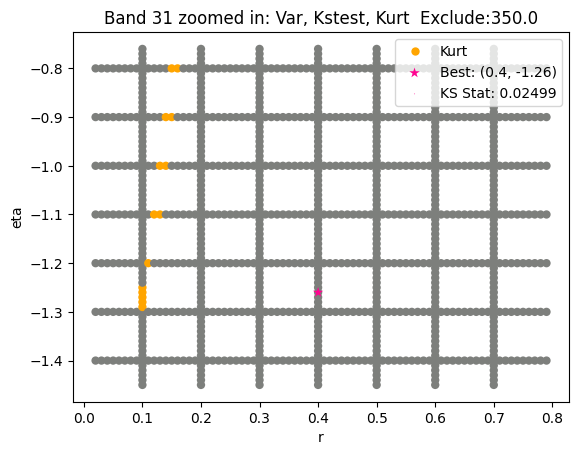

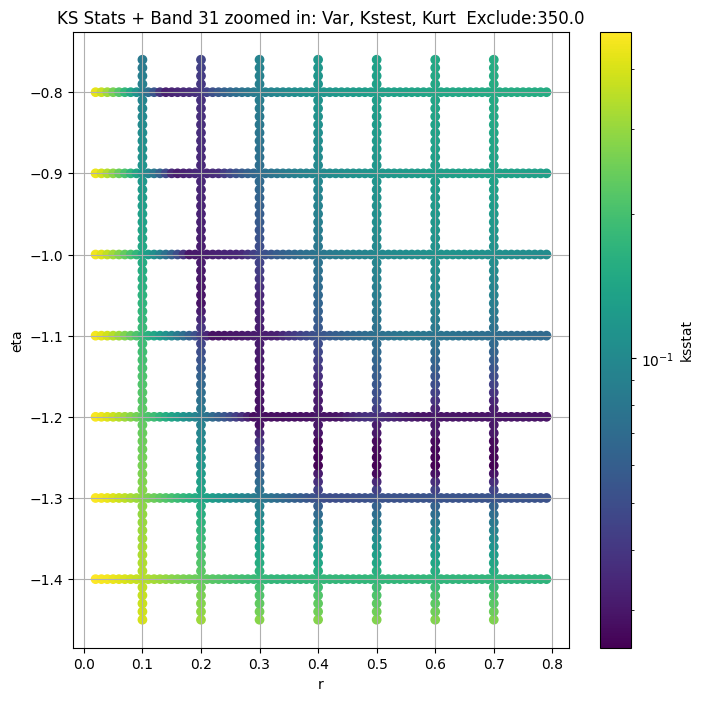

obs_var     var_lower     var_upper   obs_kurt  kurt_lower  \
band                                                                    
2     6.853443e+08  6.000959e+08  7.770957e+08  22.937462   19.237597   
5     1.720905e+09  1.589508e+09  1.857453e+09   7.161636    6.278728   
8     1.589684e+09  1.483643e+09  1.698856e+09   4.965143    4.374576   
11    1.406791e+09  1.320917e+09  1.494175e+09   3.765583    3.402681   
14    4.136414e+08  3.796874e+08  4.487363e+08   8.555159    7.603021   
18    8.658497e+07  7.946839e+07  9.422107e+07   8.942694    7.117870   
21    3.366062e+07  3.053090e+07  3.707506e+07  11.999883    8.983744   
24    1.652805e+07  1.429403e+07  1.900538e+07  28.780750   22.489761   
27    7.214118e+06  6.049044e+06  8.504491e+06  41.735855   32.778020   
31    2.225652e+05  1.780760e+05  2.839582e+05  79.637880   42.826660   

      kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
band                                                                           
2      27.805487     57630782.0             0.011945        0.1         -0.3   
5       8.114003     57630782.0             0.034588        0.2         -0.5   
8       5.578486     57630782.0             0.025058        0.2         -0.1   
11      4.146911     57630782.0             0.029154        0.2         -0.2   
14      9.561466     57630782.0             0.019528        0.2         -0.6   
18     11.266998     57630782.0             0.019642        0.2         -0.3   
21     16.473260     57630782.0             0.018456        0.2         -0.5   
24     36.190422     57630782.0             0.006889        0.2         -0.9   
27     52.597347     57630782.0             0.009754        0.2         -1.0   
31    217.259690     57630782.0             0.028403        0.3         -1.2   

      initial_scale  initial_exclude_cutoff  best_augmented_var  \
band                                                              
2          0.000510                    25.0        6.295404e+08   
5      94048.313228                   350.0        1.422010e+09   
8      28673.950938                     0.0        1.589684e+09   
11     34034.786054                     0.0        1.406791e+09   
14     39484.945138                    25.0        4.136414e+08   
18      2863.259524                     0.0        8.658497e+07   
21      2226.231217                     0.0        3.366062e+07   
24      6558.748413                     0.0        1.548686e+07   
27      3171.192186                   250.0        4.621830e+06   
31     11301.053626                   350.0        1.046537e+05   

      kstest_stat_cutoff_0.05  kstest_stat_best  best_r  best_eta  \
band                                                                
2                    0.000179          0.011080    0.14     -0.70   
5                    0.000179          0.033595    0.20     -0.51   
8                    0.000179          0.024663    0.20     -0.09   
11                   0.000179          0.027920    0.20     -0.16   
14                   0.000179          0.019021    0.20     -0.61   
18                   0.000179          0.017317    0.24     -0.50   
21                   0.000179          0.015063    0.25     -0.70   
24                   0.000179          0.005380    0.24     -1.00   
27                   0.000179          0.008460    0.24     -1.10   
31                   0.000179          0.024992    0.40     -1.26   

        best_scale  best_exclude_cutoff  n_pval_0.05  
band                                                  
2       139.893983                 50.0        15828  
5     97635.031059                350.0         1666  
8     27870.762024                  0.0         2965  
11    30198.765004                  0.0         2371  
14    42004.397973                  0.0         5275  
18    64685.954454                  0.0         5934  
21    77683.316348                  0.0         7914  
24    86971.178071                 25.0     

In [15]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS))) # By default, does one iteration per group
NUM_SAMPLES_OPTIMIZE = 2000
EXCLUDE_CUTOFFS_OPTIMIZE = np.arange(100, -101, -25)

if RERUN or not master_df_optimized_path.exists():

    if SKIP_OPTIMIZE_STEP:

        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
        master_df[f'best_scale'] = master_df['initial_scale']
        master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

    else:
        for group in GROUPS: # TODO For quick testing purposes
            print(f"{GROUP.capitalize()} {group}")
            master_df.loc[group, 'kstest_stat_best'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_eta'] = master_df.loc[group, 'initial_eta']
            master_df.loc[group, 'best_scale'] = master_df.loc[group, 'initial_scale']

            sample = group_data_map[group]
            if len(sample) == 0:
                continue
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            eps = 0.5
            group_cdfs_df = fine_cdfs_df[(np.abs(master_df.loc[group, 'initial_r'] - fine_cdfs_df['r']) < eps) & 
                                        (np.abs(master_df.loc[group, 'initial_eta'] - fine_cdfs_df['eta']) < eps)].reset_index(drop=True)
            group_cdfs = {x[0]:x[1] for x in group_cdfs_df['(r,eta),cdf']}

            for adjust_exclude_cutoff in EXCLUDE_CUTOFFS_OPTIMIZE: # -50, -25, 0, 25, 50
                
                exclude_cutoff = int(max(0, adjust_exclude_cutoff + master_df.loc[group, 'initial_exclude_cutoff']))
                
                if exclude_cutoff == 0:
                    augmented_var = np.var(group_data_map[group])
                else:
                    augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])                       

                group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
                ksstats, initial_param, min_stat = gridsearch(sample, group_cdfs, debug=True, scales=group_cdfs_df['scale'])
                
                cutoff_label = generate_cutoff_label(adjust_exclude_cutoff)

                augmented_var_df.loc[group, f"kstest_stat_{cutoff_label}"] = min_stat
                group_cdfs_df[f'ksstat_exclude_{cutoff_label}'] = ksstats
                
                print(f"{GROUP} {group}, {master_df.loc[group, 'initial_exclude_cutoff']} + {adjust_exclude_cutoff} = {exclude_cutoff}, ksstat: {min_stat}, var: {augmented_var}")
                best_adjust = 0

                if min_stat < master_df.loc[group, 'kstest_stat_best']:

                    inital_min_stat = min_stat
                    inital_best_param = initial_param
                    master_df.loc[group, 'kstest_stat_best'] = min_stat
                    initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                    master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'] = initial_param
                    master_df.loc[group, 'best_scale'] = initial_scale
                    master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
                    master_df.loc[group, 'best_augmented_var'] = augmented_var
                    augmented_var_df.loc[group, 'best_augmented_var'] = augmented_var
                    best_adjust = adjust_exclude_cutoff

                if exclude_cutoff == 0:
                    break

            cutoff_label = generate_cutoff_label(best_adjust)
            ksstats = group_cdfs_df[f"ksstat_exclude_{cutoff_label}"]
            
            print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
            
            cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
            master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

            best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

            group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
            group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

            group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

            group_dict = rEtaKsstats_dict[group]
            group_dict.update({'r_optimize' : group_cdfs_df['r'], 'eta_optimize' : group_cdfs_df['eta'], f'ksstat_exclude_{cutoff_label}' : ksstats})
            rEtaKsstats_dict[group] = group_dict

            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(group_cdfs_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}  Exclude:{master_df.loc[group, 'best_exclude_cutoff']}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=master_df.loc[group, 'kstest_stat_best'])
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'initial_exclude_cutoff', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'best_exclude_cutoff', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    augmented_var_df.to_csv(augmented_var_df_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)

rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
augmented_var_df = pd.read_csv(augmented_var_df_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

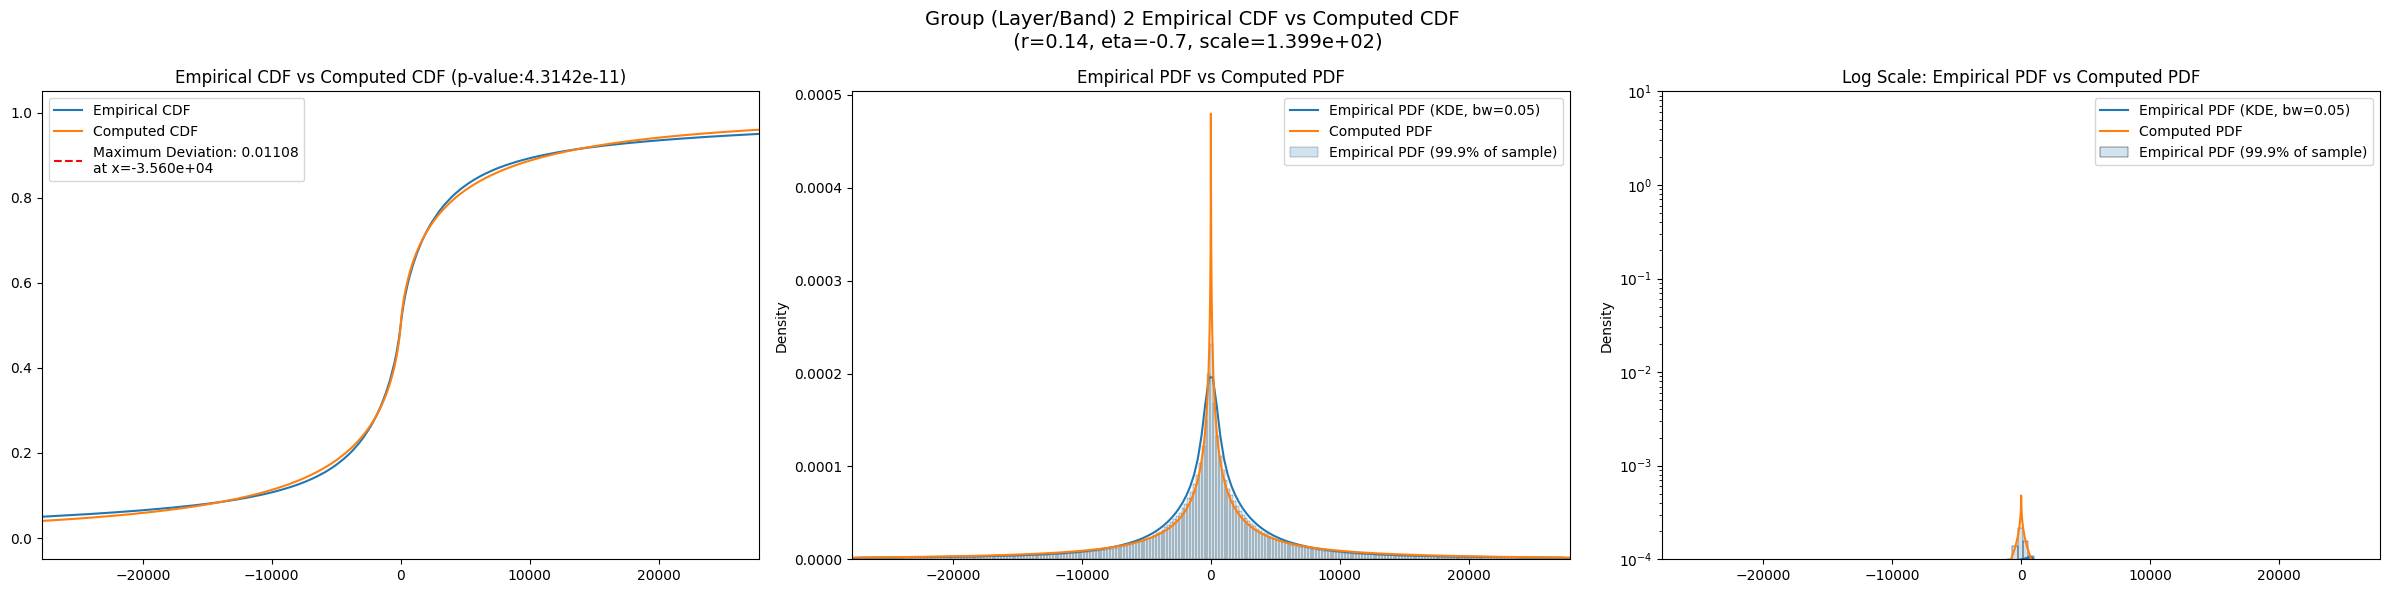

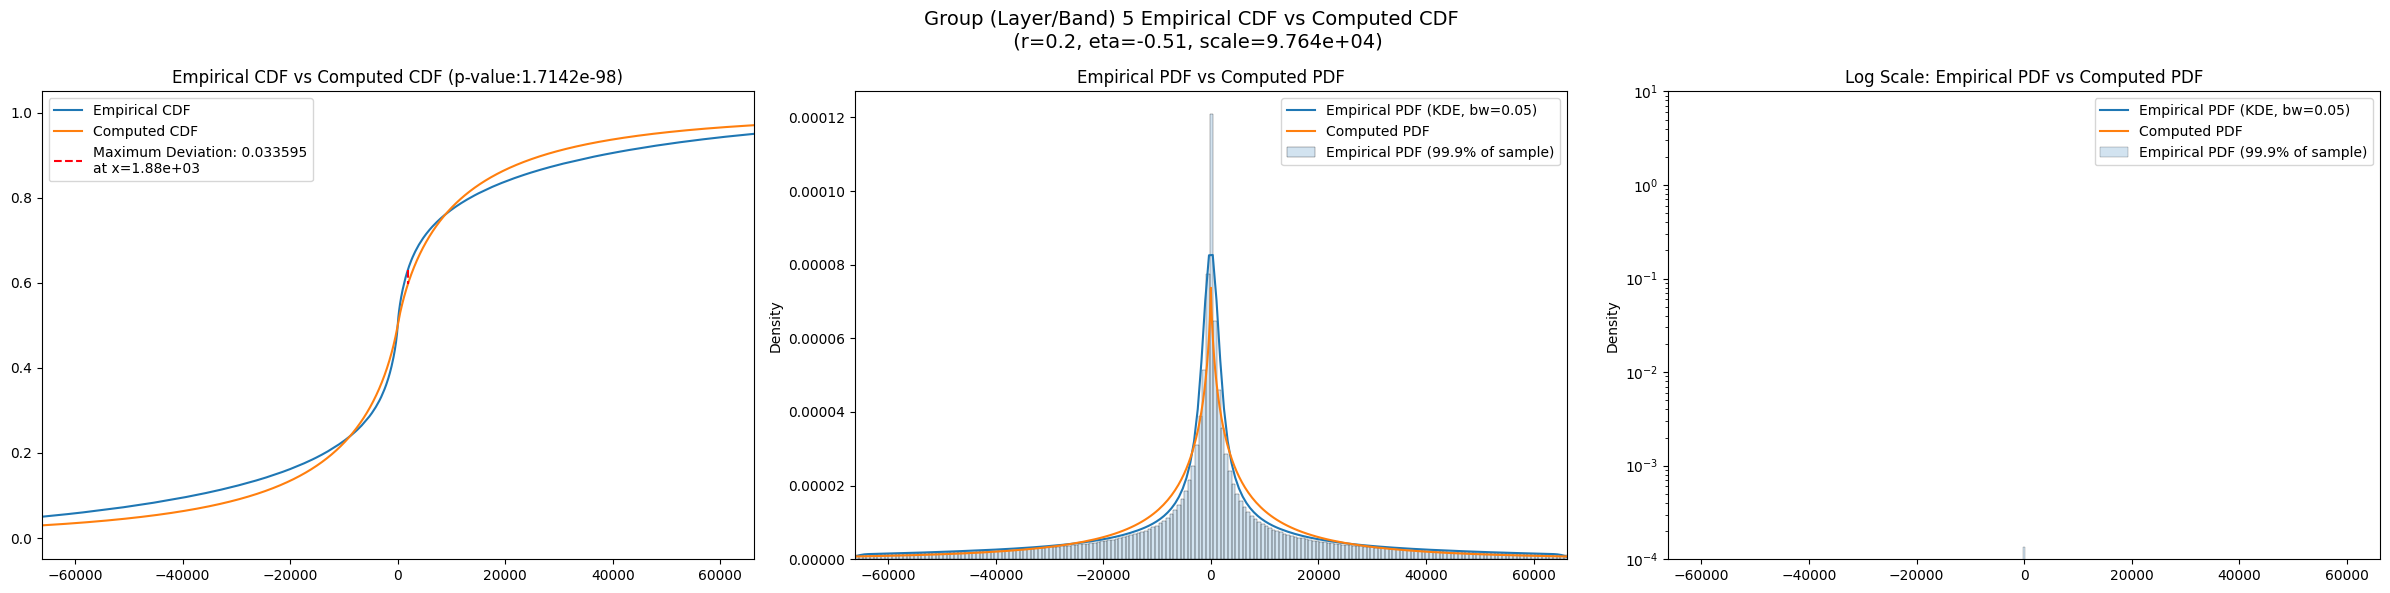

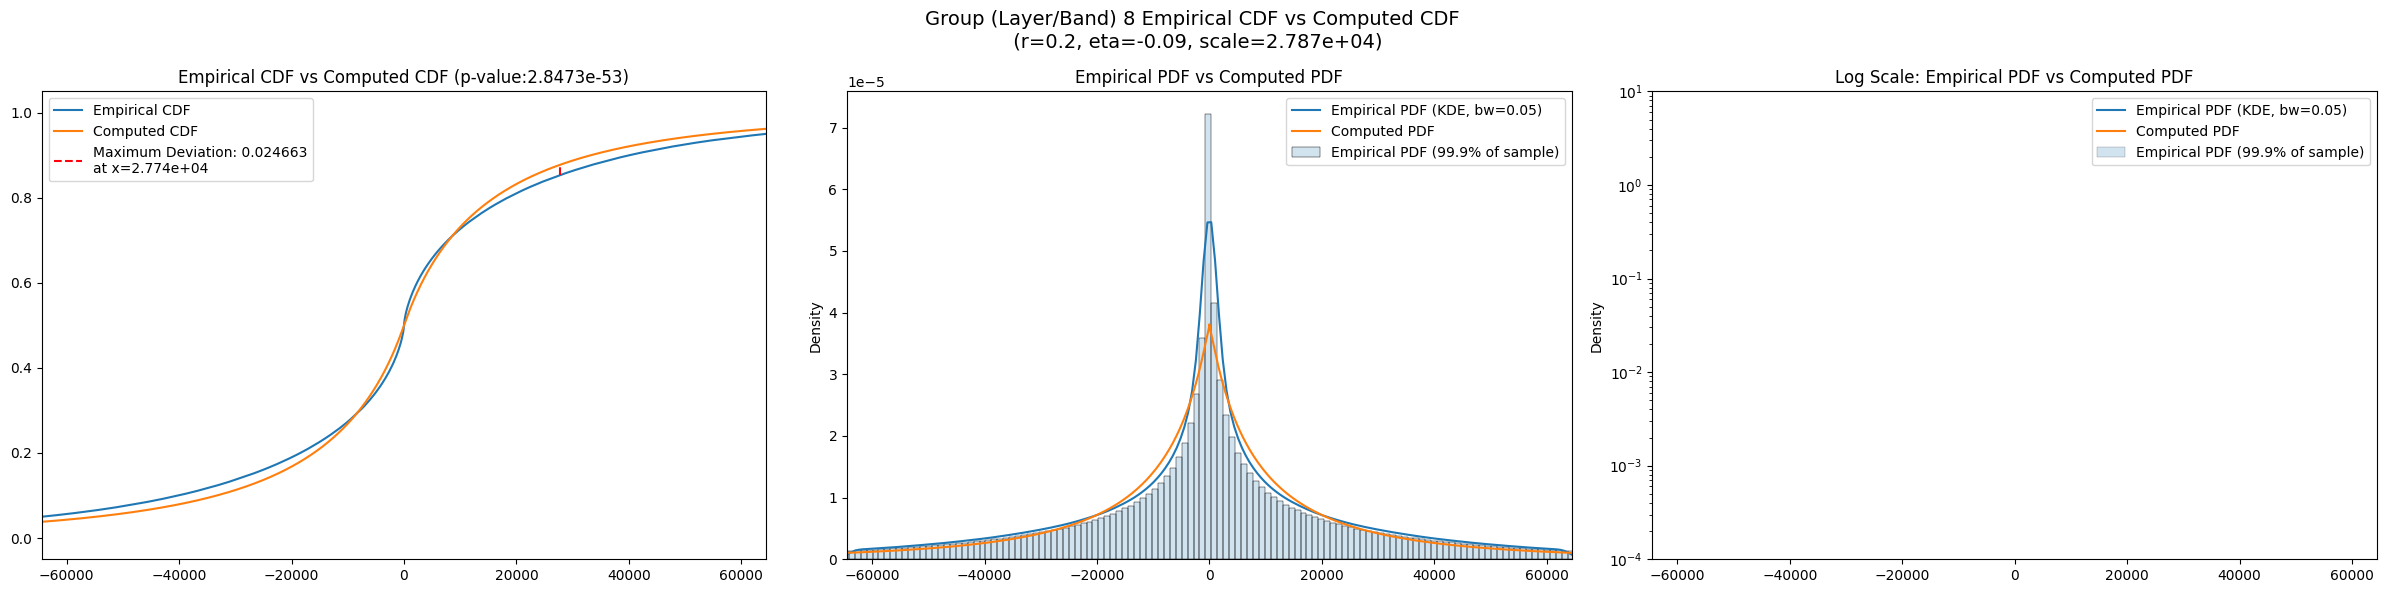

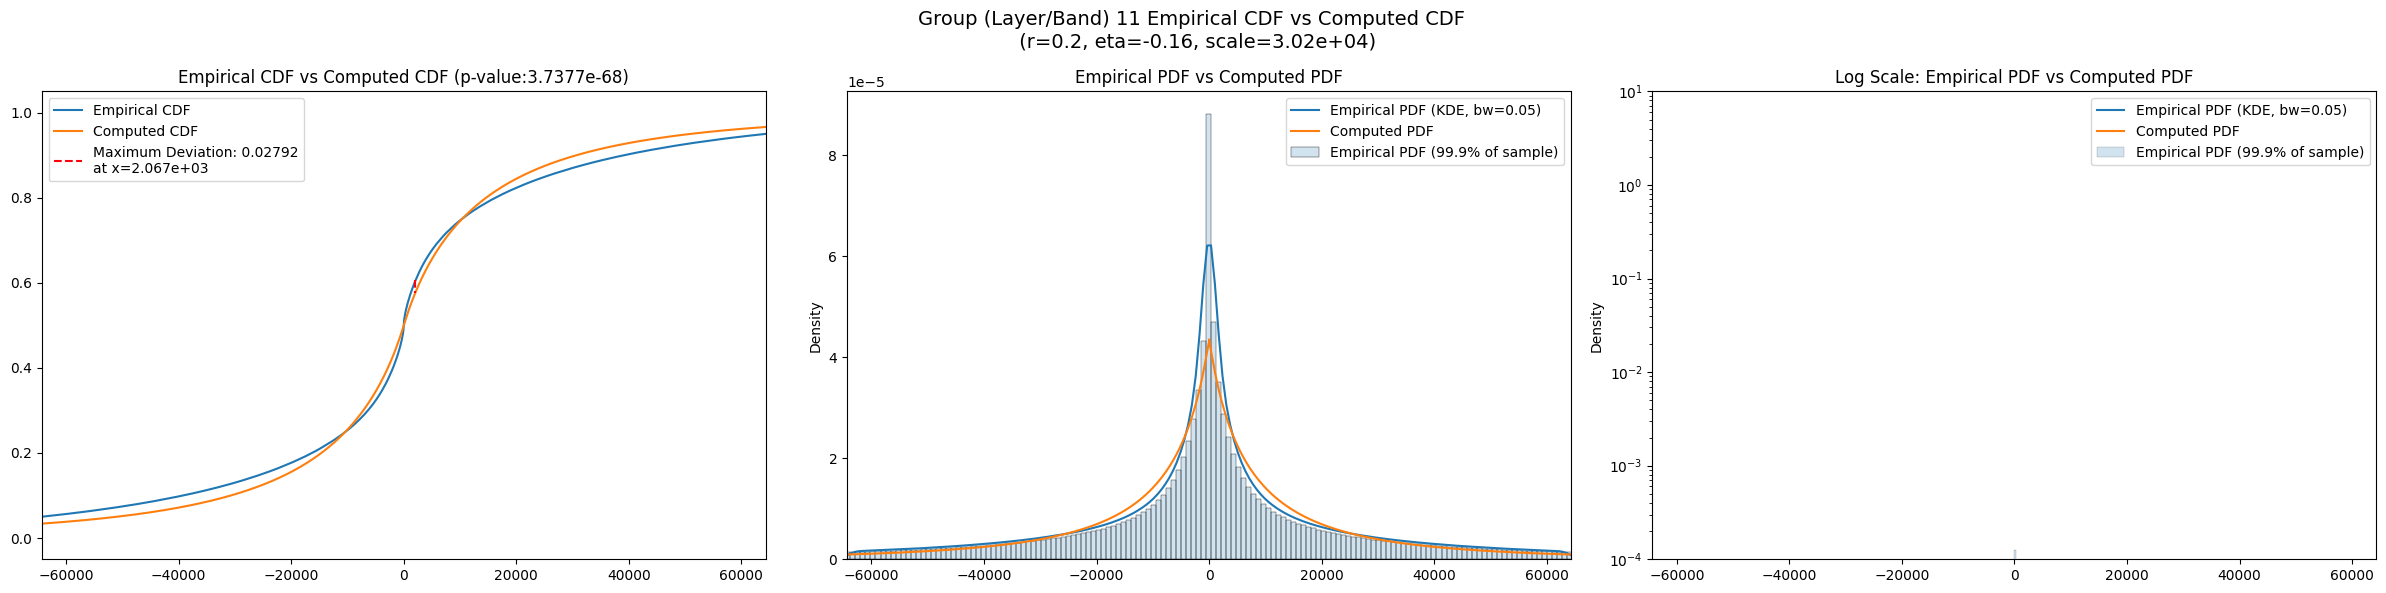

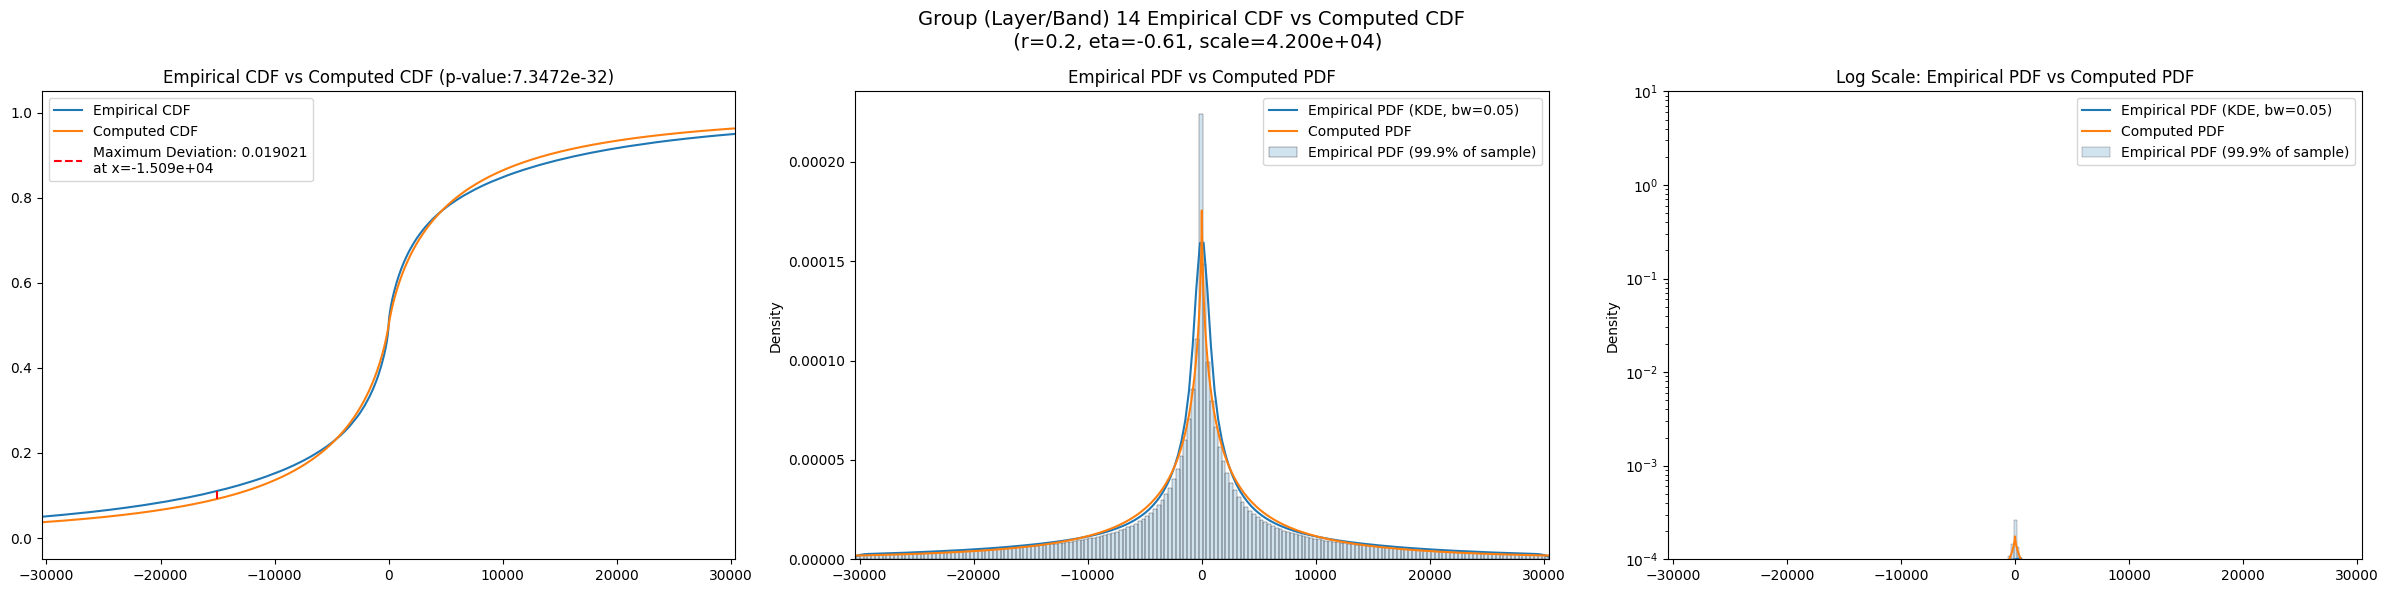

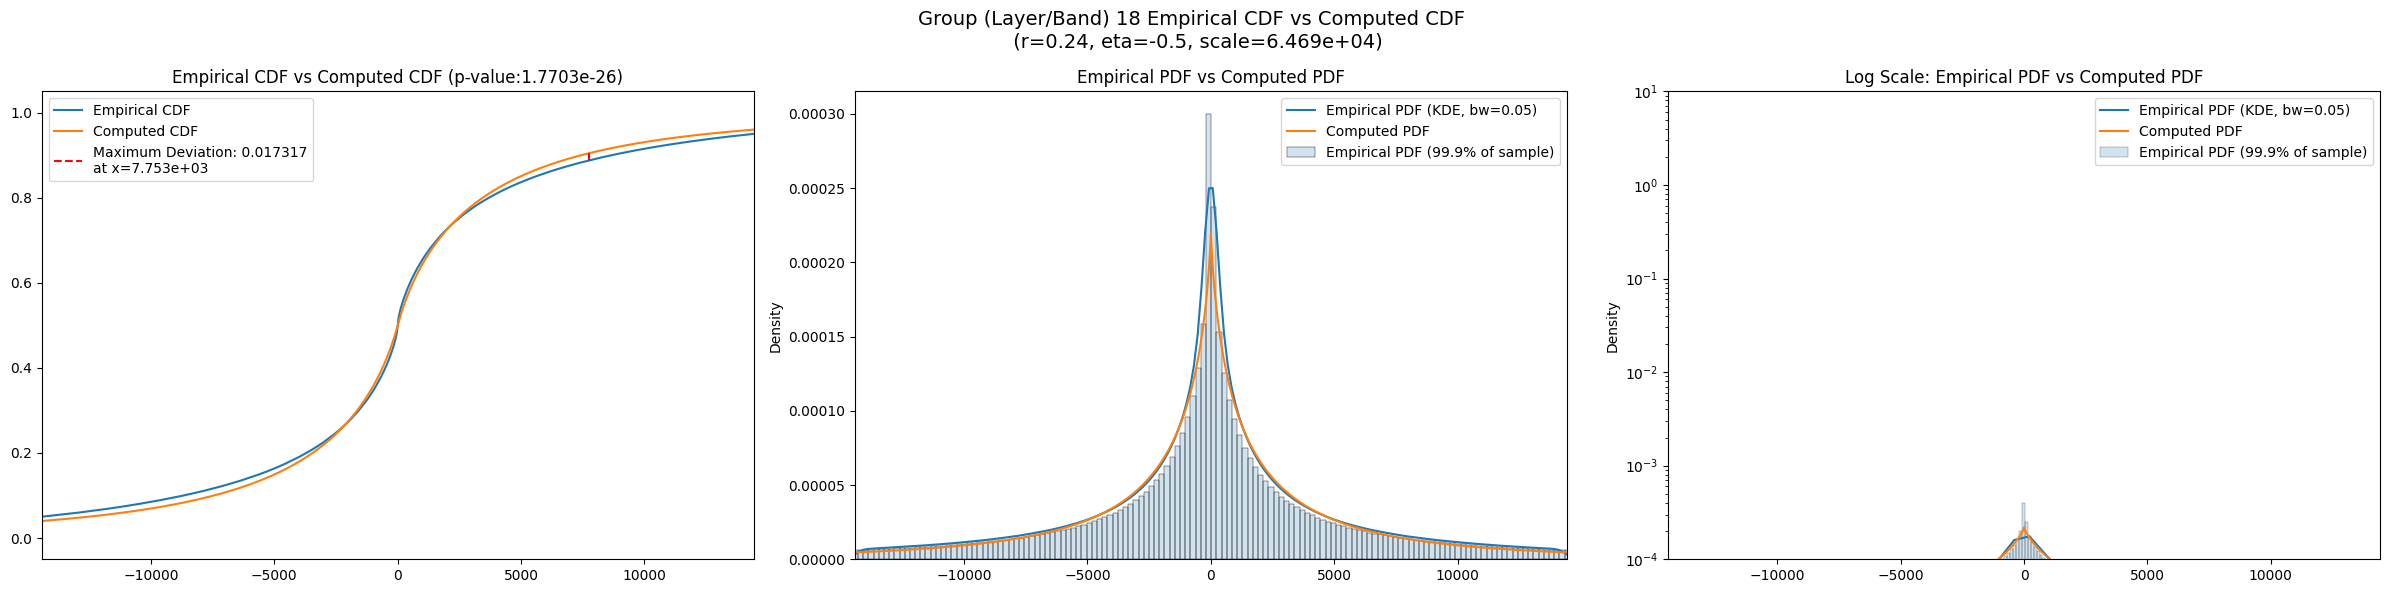

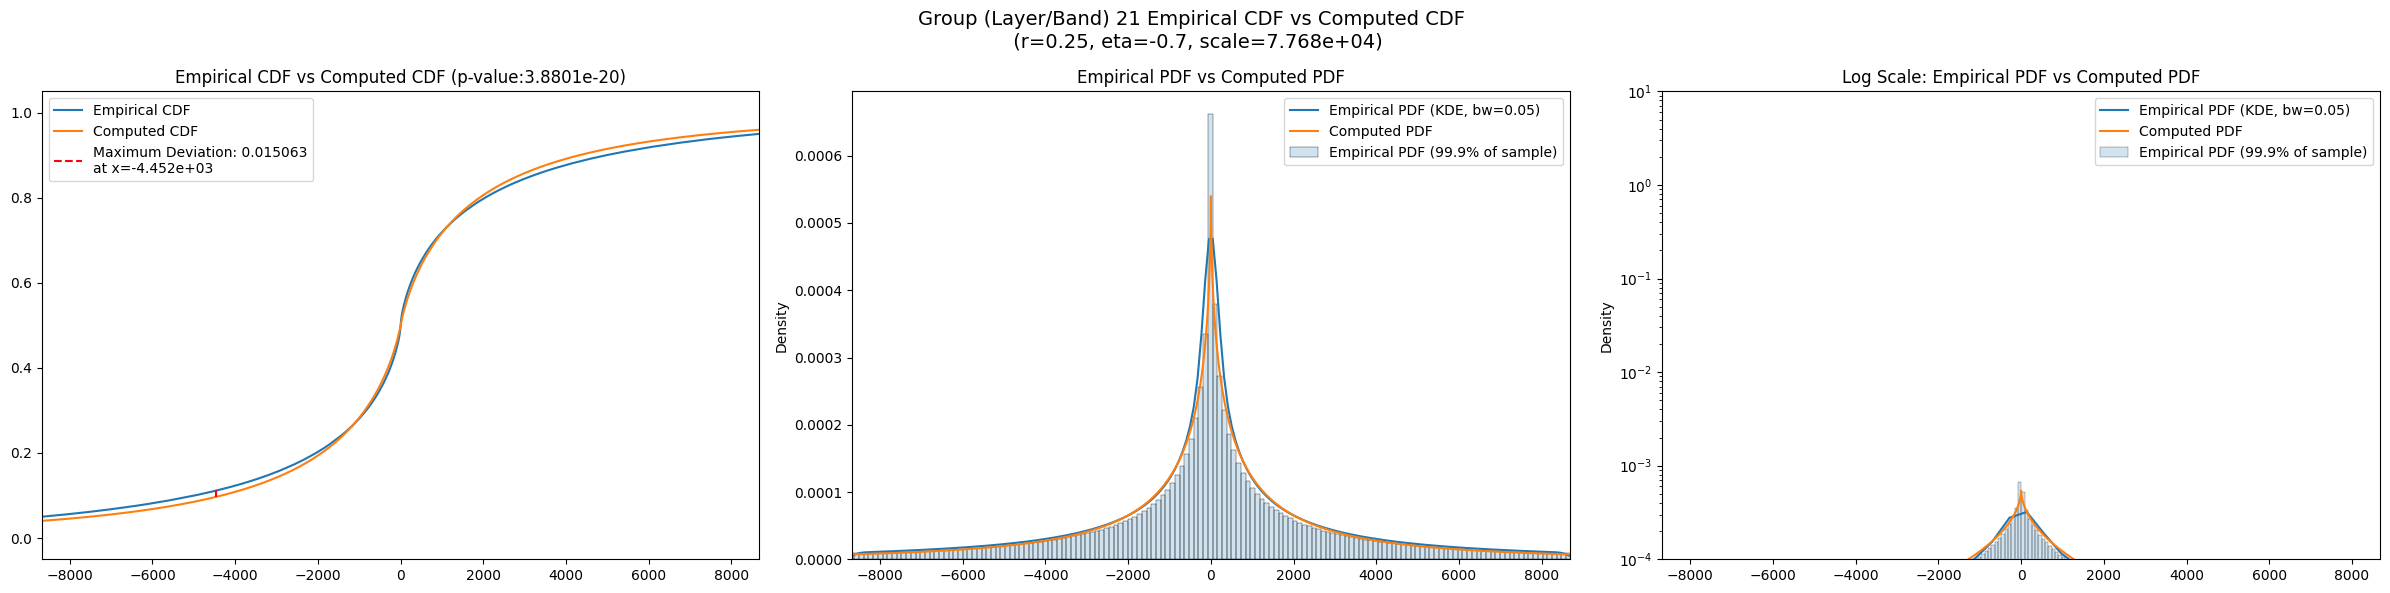

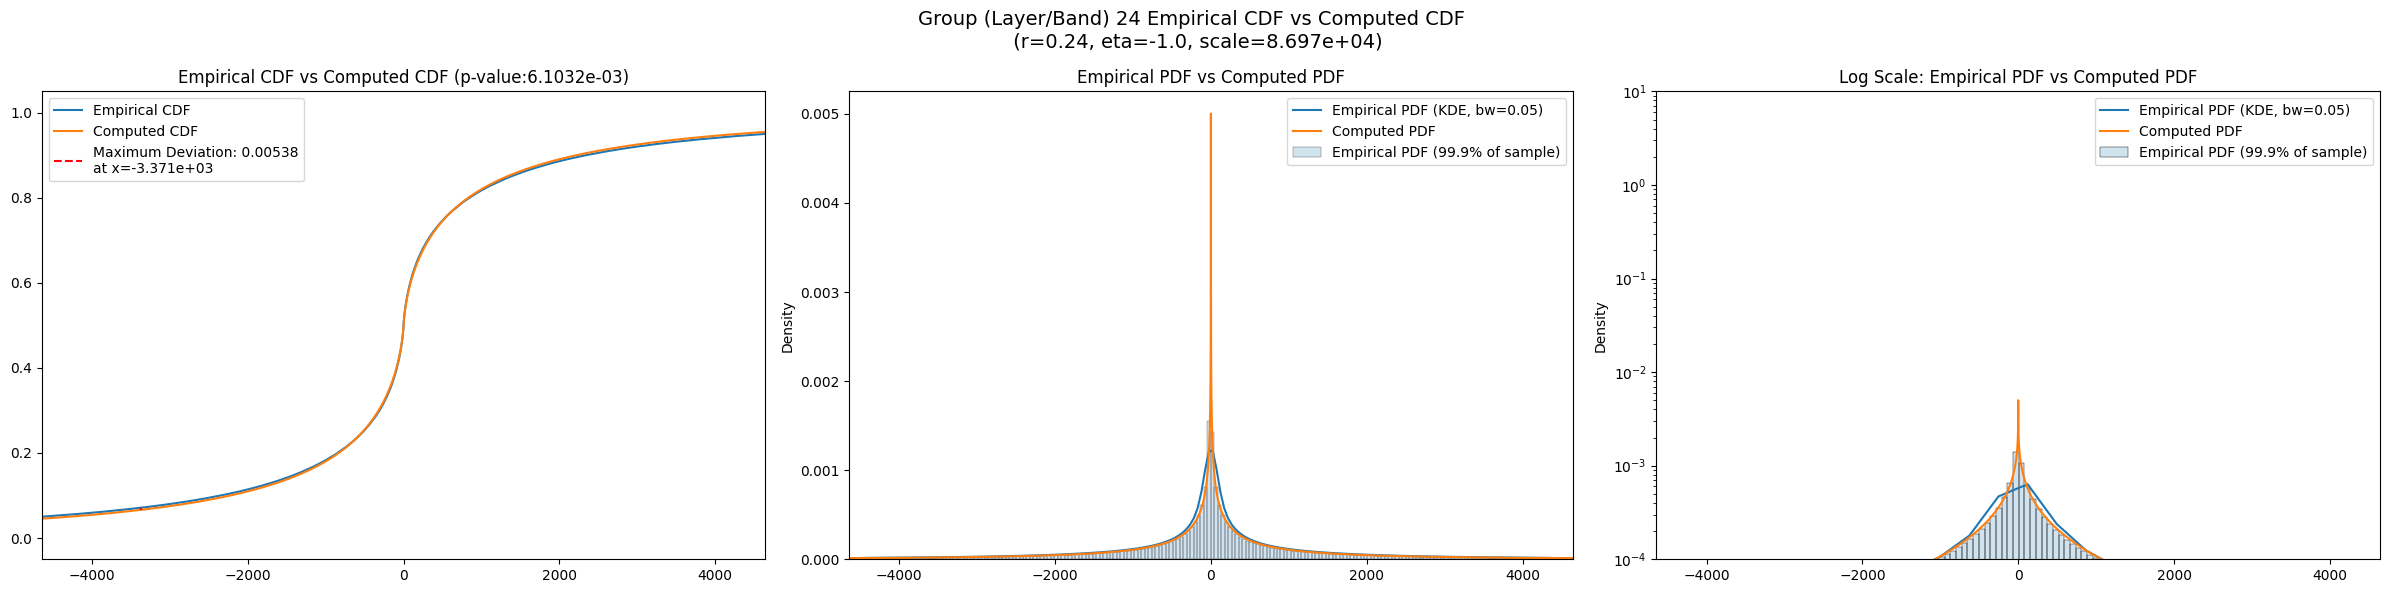

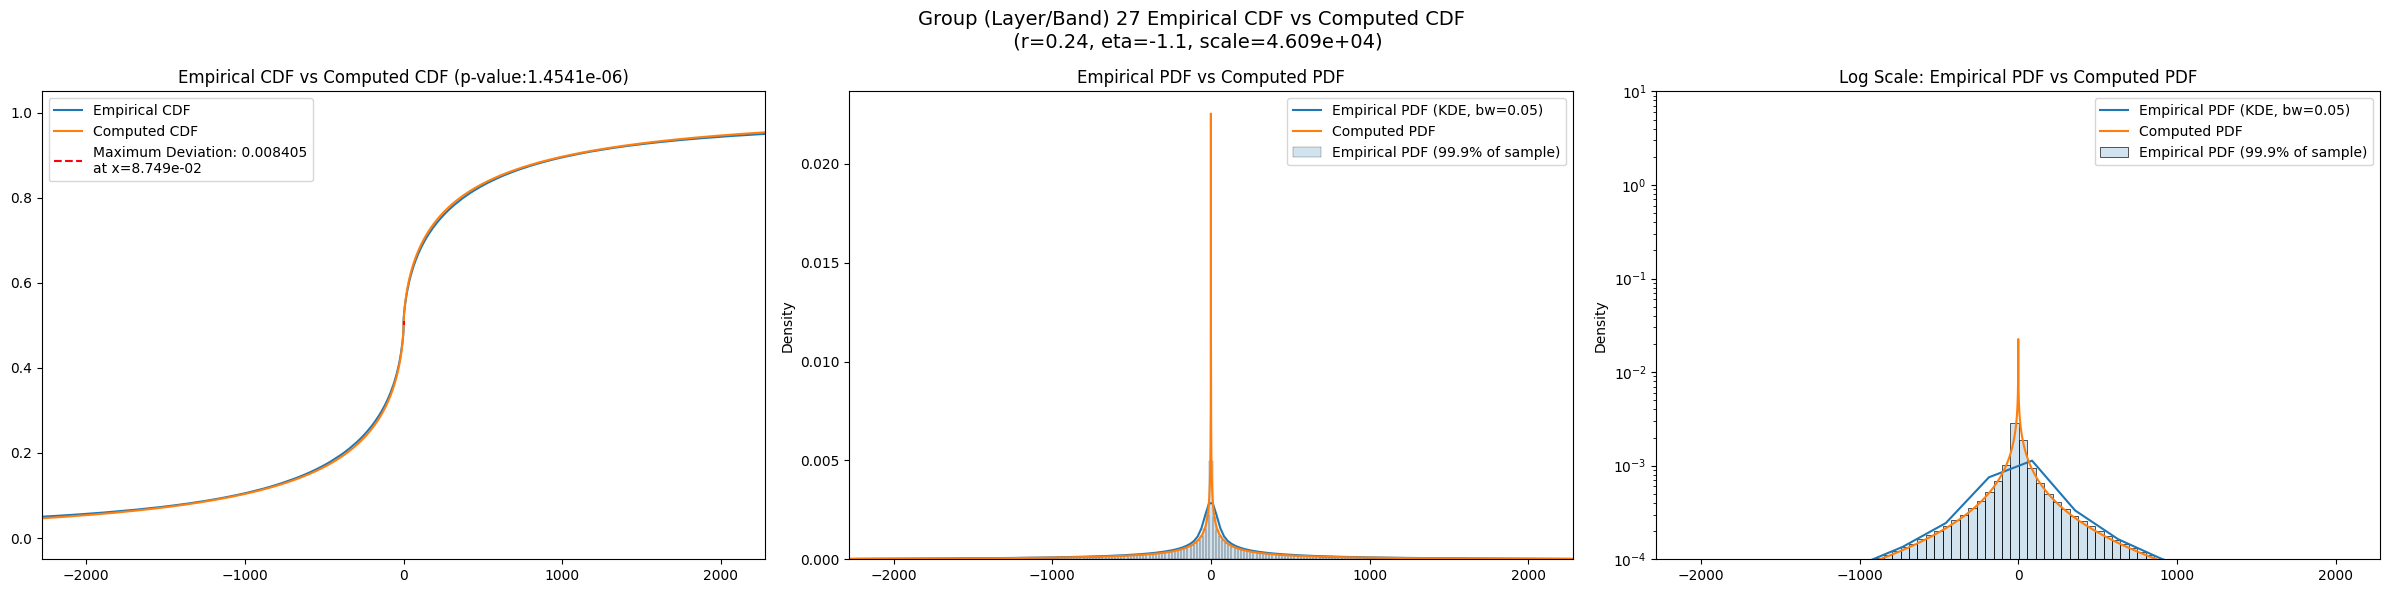

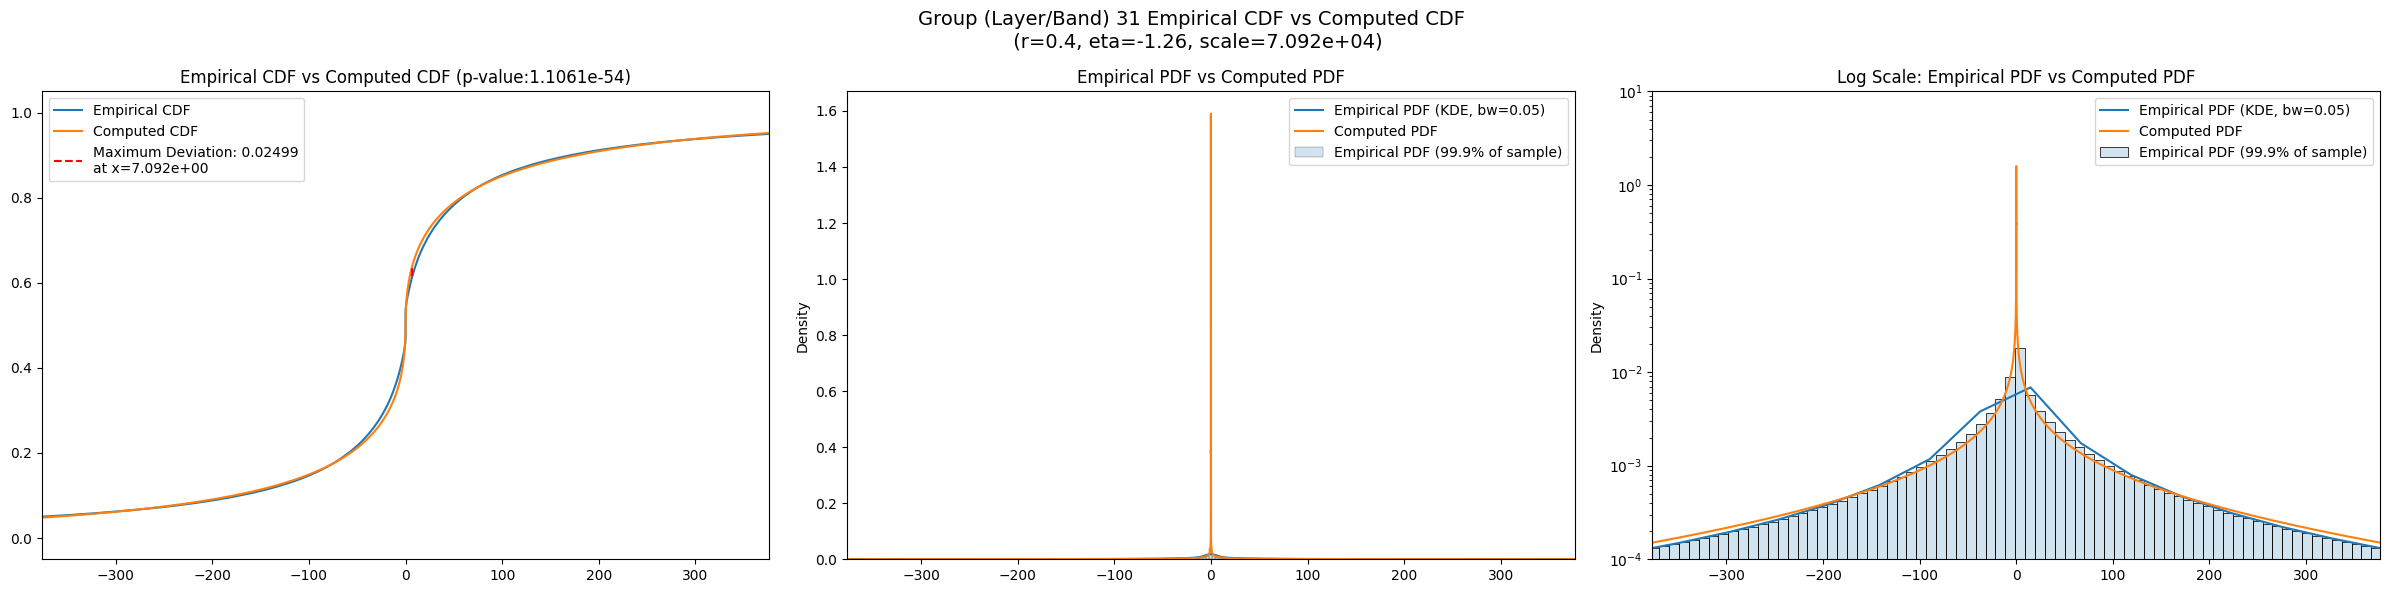

In [16]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)

## Comparing with Gaussian and Laplace Priors

In [17]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            print(r, eta, scale)
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample/ np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [18]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        if len(group_data_map[group]) == 0:
            continue
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

obs_var     var_lower     var_upper   obs_kurt  kurt_lower  \
band                                                                    
2     6.853443e+08  6.000959e+08  7.770957e+08  22.937462   19.237597   
5     1.720905e+09  1.589508e+09  1.857453e+09   7.161636    6.278728   
8     1.589684e+09  1.483643e+09  1.698856e+09   4.965143    4.374576   
11    1.406791e+09  1.320917e+09  1.494175e+09   3.765583    3.402681   
14    4.136414e+08  3.796874e+08  4.487363e+08   8.555159    7.603021   
18    8.658497e+07  7.946839e+07  9.422107e+07   8.942694    7.117870   
21    3.366062e+07  3.053090e+07  3.707506e+07  11.999883    8.983744   
24    1.652805e+07  1.429403e+07  1.900538e+07  28.780750   22.489761   
27    7.214118e+06  6.049044e+06  8.504491e+06  41.735855   32.778020   
31    2.225652e+05  1.780760e+05  2.839582e+05  79.637880   42.826660   

      kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
band                                                                           
2      27.805487     57630782.0             0.011945        0.1         -0.3   
5       8.114003     57630782.0             0.034588        0.2         -0.5   
8       5.578486     57630782.0             0.025058        0.2         -0.1   
11      4.146911     57630782.0             0.029154        0.2         -0.2   
14      9.561466     57630782.0             0.019528        0.2         -0.6   
18     11.266998     57630782.0             0.019642        0.2         -0.3   
21     16.473260     57630782.0             0.018456        0.2         -0.5   
24     36.190422     57630782.0             0.006889        0.2         -0.9   
27     52.597347     57630782.0             0.009754        0.2         -1.0   
31    217.259690     57630782.0             0.028403        0.3         -1.2   

      ...  param_gaussian  kstest_stat_gaussian  kstest_pval_gaussian  \
band  ...                                                               
2     ...       5525.8800              0.080258                   0.0   
5     ...      16126.2000              0.093276                   0.0   
8     ...      21950.1000              0.067216                   0.0   
11    ...      19763.5000              0.076785                   0.0   
14    ...       7875.6400              0.083741                   0.0   
18    ...       4663.2100              0.069941                   0.0   
21    ...       2554.3000              0.075190                   0.0   
24    ...       1056.0000              0.087381                   0.0   
27    ...        467.2760              0.089359                   0.0   
31    ...         75.1768              0.089223                   0.0   

      param_laplace  kstest_stat_laplace  kstest_pval_laplace     param_t  \
band                                                                        
2         4993.2200             0.057450                  0.0   3725.1000   
5        13755.3000             0.068740                  0.0  10653.1000   
8        18603.6000             0.042750                  0.0  14887.1000   
11       16921.2000             0.051209                  0.0  13360.7000   
14        6778.9000             0.058434                  0.0   5263.0700   
18        4008.0700             0.044131                  0.0   3151.3900   
21        2190.4900             0.049987                  0.0   1708.0600   
24         907.7620             0.063125                  0.0    694.9020   
27         399.2620             0.065980                  0.0    303.4520   
31          64.6046             0.066117                  0.0     48.5833   

      kstest_stat_t  kstest_pval_t  kstest_pval_gengamma  
band                                                      
2          0.052970            0.0                   0.0  
5          0.069856            0.0                   0.0  
8          0.046658            0.0                   0.0  
11         0.053710            0.0                   0.0  
14         0.0594

## Results

In [19]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [20]:
master_df.filter(regex="kstest_stat.*")

kstest_stat_initial  kstest_stat_cutoff_0.05  kstest_stat_best  \
band                                                                   
2                0.011945                 0.000179          0.011080   
5                0.034588                 0.000179          0.033595   
8                0.025058                 0.000179          0.024663   
11               0.029154                 0.000179          0.027920   
14               0.019528                 0.000179          0.019021   
18               0.019642                 0.000179          0.017317   
21               0.018456                 0.000179          0.015063   
24               0.006889                 0.000179          0.005380   
27               0.009754                 0.000179          0.008460   
31               0.028403                 0.000179          0.024992   

      kstest_stat_gaussian  kstest_stat_laplace  kstest_stat_t  
band                                                            
2                 0.080258             0.057450       0.052970  
5                 0.093276             0.068740       0.069856  
8                 0.067216             0.042750       0.046658  
11                0.076785             0.051209       0.053710  
14                0.083741             0.058434       0.059432  
18                0.069941             0.044131       0.046313  
21                0.075190             0.049987       0.051632  
24                0.087381             0.063125       0.063370  
27                0.089359             0.065980       0.066177  
31                0.089223             0.066117       0.065731

In [21]:
master_df.filter(regex="best.*")

best_augmented_var  kstest_stat_best  best_r  best_eta    best_scale  \
band                                                                         
2           6.295404e+08          0.011080    0.14     -0.70    139.893983   
5           1.422010e+09          0.033595    0.20     -0.51  97635.031059   
8           1.589684e+09          0.024663    0.20     -0.09  27870.762024   
11          1.406791e+09          0.027920    0.20     -0.16  30198.765004   
14          4.136414e+08          0.019021    0.20     -0.61  42004.397973   
18          8.658497e+07          0.017317    0.24     -0.50  64685.954454   
21          3.366062e+07          0.015063    0.25     -0.70  77683.316348   
24          1.548686e+07          0.005380    0.24     -1.00  86971.178071   
27          4.621830e+06          0.008460    0.24     -1.10  46087.806981   
31          1.046537e+05          0.024992    0.40     -1.26  70917.400944   

      best_exclude_cutoff  
band                       
2                    50.0  
5                   350.0  
8                     0.0  
11                    0.0  
14                    0.0  
18                    0.0  
21                    0.0  
24                   25.0  
27                  225.0  
31                  350.0